## Covid19 Projection
The purpose of this notebook is to run Covid-19 case projections at State or Country levels. The outcome is the projection of the total confirmed cases for the target geography. 

This solution first tries to understand the approximate time to peak for the target entity (state/country), expected case rates and higher/lower bounds. It determines these parameters from countries that have exhibited similar trends in the past. 

Next, it determines the best simulation parameters in terms of transmission probability and weeks to peak by running the simulator iteratively with values from a parameter space.

Finally, it runs a simulation with the optimized parameters to generate day by day case projections. The simulation assumes 2 waves of infection surges following gaussian distribution and tries to apply that in generating the case projections. It also incorporates various factors like transmission probability, testing efficiency, intervention impacts etc.

Note: interventions_scorer.ipynb should be excuted prior to running the projections on new data

In [1]:
#!pip install -r requirements.txt

In [1]:
import sys
sys.path.insert(1, 'src')
import pandas as pd
import numpy as np
import random
import config
import state_data_loader
import country_data_loader
import urllib.request
import os

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from simulation_orchestrator import run

This simulation works best for a timeline when the infection is trending upward, i.e. it is able to find a greater than 1 transmission-rate and a postive time-to-peak from the recent data. As samples, we have used a few states from India and USA as the country for demonstration.

### Fetch latest data for target States / Countries

In [3]:
# Set this flag to True if you want to download the latest COVID19 cases data from respective web sources
LOAD_LATEST_DATA = True

# * * * Run interventions_scorer.ipynb everytime you download the latest data.

In [4]:
if LOAD_LATEST_DATA:
    
    # Function to refresh the local data file with the latest version from the web
    def download_latest_data (url, local_file):
        with urllib.request.urlopen(url) as response, open(local_file, 'wb') as out_file:
            data = response.read() # a `bytes` object
            out_file.write(data)
    
    # Mapping of online vs offline file locations to refresh
    online_offline_data = list()
    # Confirmed cases data maintained by Johns Hopkins University
    online_offline_data.append((config.confirmed_cases_global_online, 
                                os.path.join(config.base_data_dir, config.confirmed_cases_global_offline)))
    # Recovered cases data maintained by Johns Hopkins University
    online_offline_data.append((config.recovered_cases_global_online, 
                                os.path.join(config.base_data_dir, config.recovered_cases_global_offline)))
    # Deceased cases data maintained by Johns Hopkins University
    online_offline_data.append((config.deceased_cases_global_online, 
                                os.path.join(config.base_data_dir, config.deceased_cases_global_offline)))
    # Indian states specific cases maintained by COVID19INDIA (www.covid19india.org)
    online_offline_data.append((config.india_states_cases_online, 
                                os.path.join(config.base_data_dir, config.india_states_cases_offline)))
    
    # Refresh the local data files with the latest versions from respective web sources
    for path_pair in online_offline_data:
        try:
            download_latest_data (path_pair[0], path_pair[1])
            print ('Downloaded latest data from: {}'.format(path_pair[0]))
        except Exception as e:
            print ('Error while downloading {}: {}'.format(path_pair[0], e.__class__))
    
    # Transform and write the coutry specific data for further processing
    country_data_loader.load()
    
    target_states = ['KA', 'KL', 'MH', 'GJ', 'WB']
    # Transform and write the Indian states specific data for further processing
    state_data_loader.load('India', target_states)

Downloaded latest data from: https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv
Downloaded latest data from: https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv
Downloaded latest data from: https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv
Downloaded latest data from: https://api.covid19india.org/csv/latest/state_wise_daily.csv
Storing data for country: Afghanistan  * * * * * * * * * *
Storing data for country: Algeria  * * * * * * * * * *
Storing data for country: Argentina  * * * * * * * * * *
Storing data for country: Armenia  * * * * * * * * * *
Storing data for country: Australia  * * * * * * * * * *
Storing data for country: Austria  * * * * * * * * * *
Storing data for country: Azerbaija

### Important parameters:

#### projection_days
- Number of days to project confirmed COVID19 cases for, including the test_days.

#### country_code, state, state_population, actual_testing_capacity
- Target location specific parameters
- state, state_population parameters to represent the target country when projecting for a country

##### These parameters should be configured based on the target location and current day before running the projections.

*** Additional configurable parameters can be managed in src/config.python

In [7]:
config.optimization_trials_low = 40

### Projections for Countries

Data Availability Timeline: 2020-01-23 00:00:00 to 2020-10-29 00:00:00
w1_start_dt: 2020-03-13 00:00:00 | w1_peak_dt: 2020-04-20 00:00:00 | w2_start_dt: 2020-05-30 00:00:00 | days_between_disease_waves: 90
Case Rt: 20524.153846153848 [0.006587610660823952 %]  |  Init Case Rt: 3032.2000000000007 [0.0009732412451923627 %]
Case Rate: 3032.2000000000007, Incidence Rate: 6.951723179945447e-05, Projection Population: 3000, Scaling Factor: 47.95
Optimization params config: tranmission_control_range: (0.05, 1.0) | wave1_weeks_range: (4, 6) | n_calls: 40
[Real(low=0.05, high=1.0, prior='log-uniform', transform='identity')]

****************************************************************************************************
Learning Iterations # 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,
****************************************************************************************************
Lowest Error Observed: 519598107.21501803

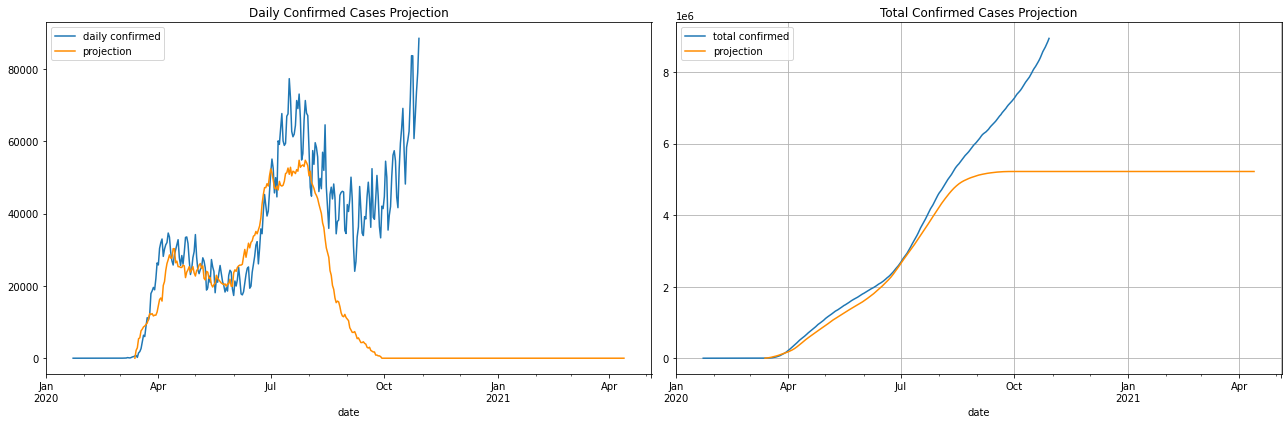



Simulation 2: using 50% end-to-end aggregated interventions:


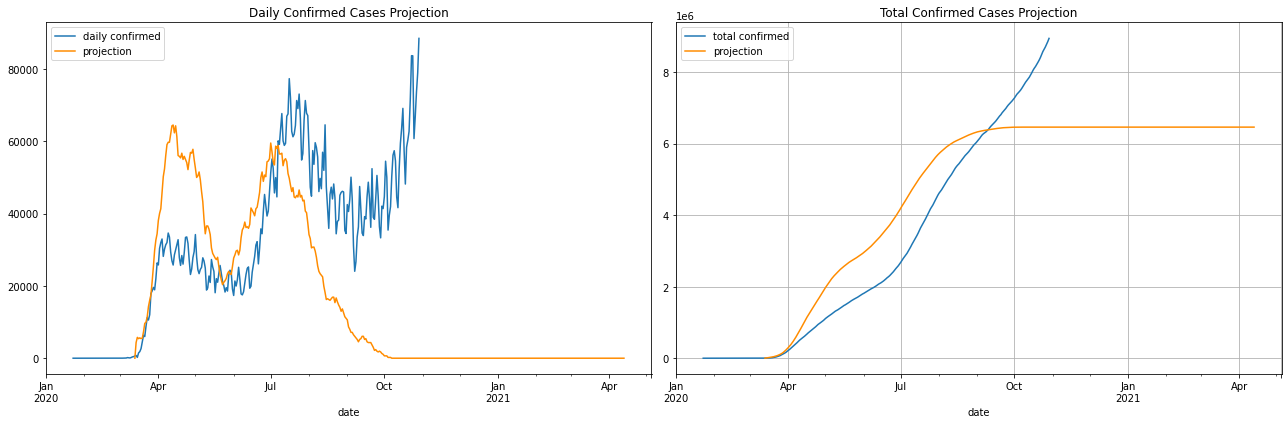



Simulation 3: using 90% end-to-end aggregated interventions:


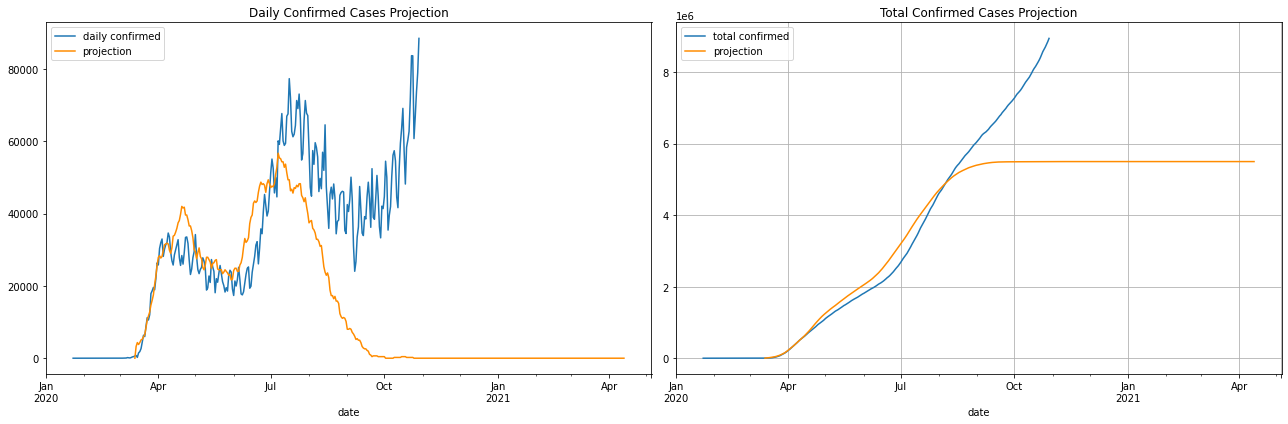

Total Time Taken: 0:06:07.015132


In [8]:
country_code, state, state_population, actual_testing_capacity = 'USA', 'US', 311556874, 700000
future_projection_days = 90

run (country_code, state, state_population, actual_testing_capacity, future_projection_days, country_level_projection=True)

Data Availability Timeline: 2020-01-23 00:00:00 to 2020-10-29 00:00:00
w1_start_dt: 2020-03-13 00:00:00 | w1_peak_dt: 2020-04-23 00:00:00 | w2_start_dt: 2020-08-19 00:00:00 | days_between_disease_waves: 200
Case Rt: 1114.5714285714287 [0.003012355212355213 %]  |  Init Case Rt: 156.25 [0.0004222972972972973 %]
Case Rate: 156.25, Incidence Rate: 3.016409266409266e-05, Projection Population: 3000, Scaling Factor: 110.507
Optimization params config: tranmission_control_range: (0.05, 1.0) | wave1_weeks_range: (5, 7) | n_calls: 40
[Real(low=0.05, high=1.0, prior='log-uniform', transform='identity')]

****************************************************************************************************
Learning Iterations # 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,
****************************************************************************************************
Lowest Error Observed: 1773472.7231726944
Best Param(s): [0.51

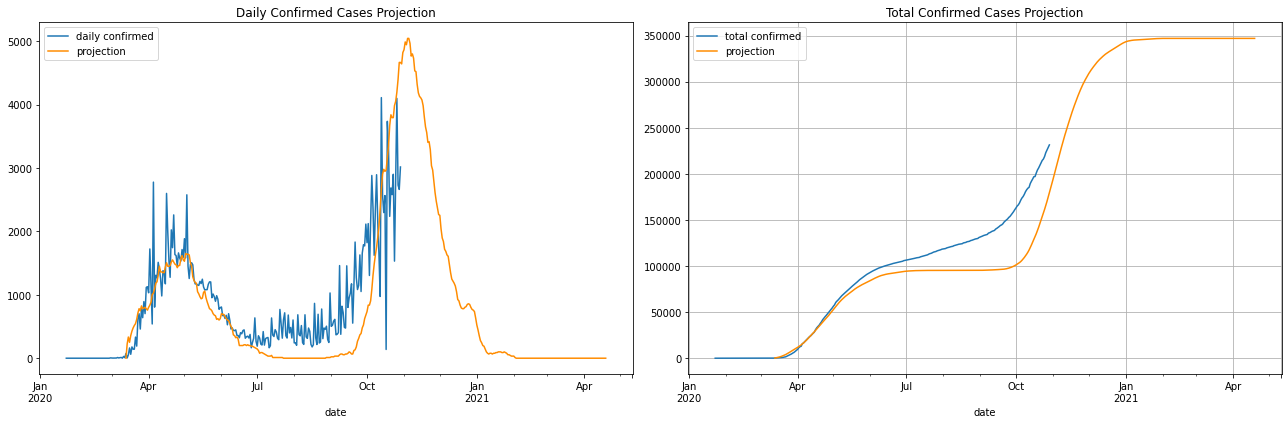



Simulation 2: using 50% end-to-end aggregated interventions:


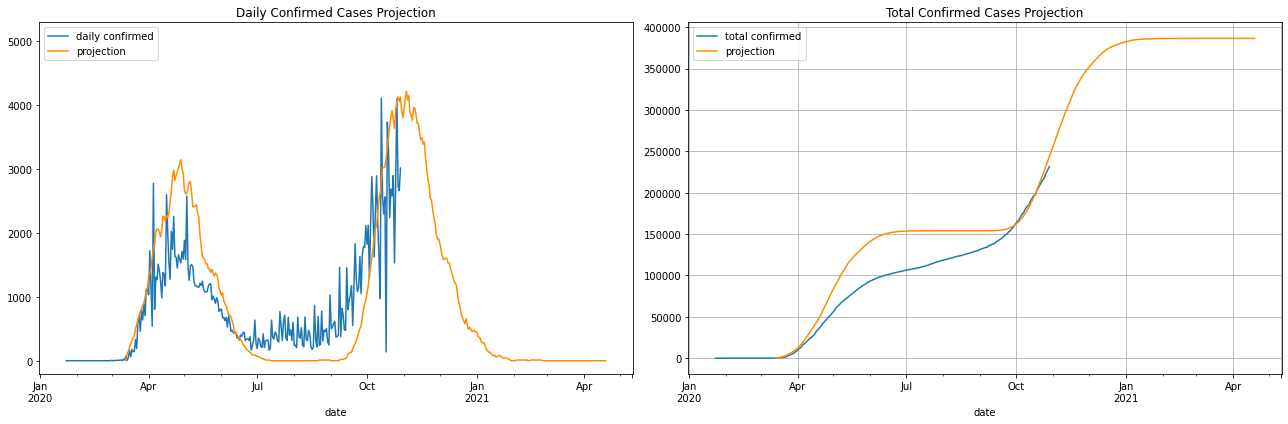



Simulation 3: using 90% end-to-end aggregated interventions:


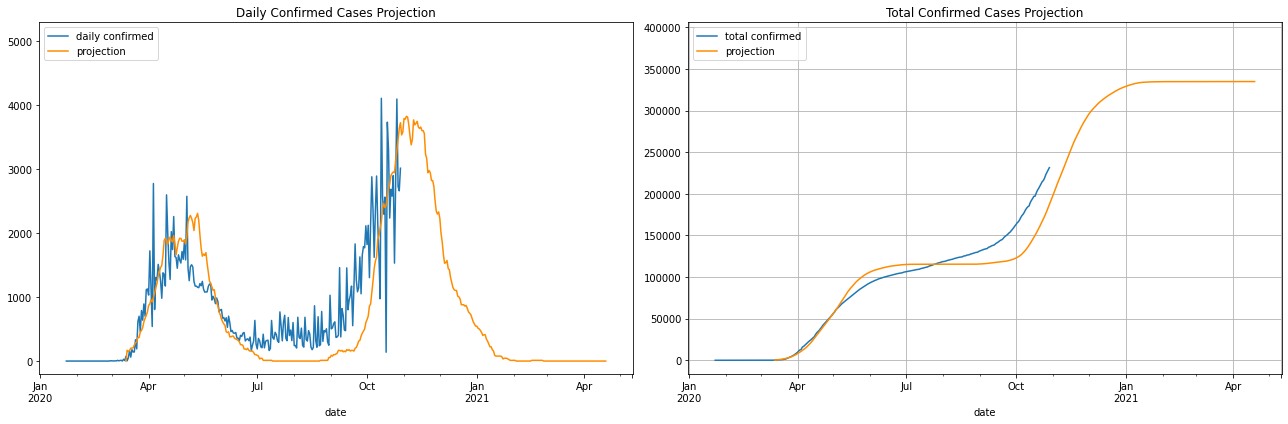

Total Time Taken: 0:06:29.341754


In [9]:
country_code, state, state_population, actual_testing_capacity = 'CAN', 'Canada', 37000000, 90000
future_projection_days = 90

run (country_code, state, state_population, actual_testing_capacity, future_projection_days, country_level_projection=True)

Data Availability Timeline: 2020-01-23 00:00:00 to 2020-10-29 00:00:00
w1_start_dt: 2020-05-21 00:00:00 | w1_peak_dt: None | w2_start_dt: None | days_between_disease_waves: None
Case Rt: 7011.972222222223 [0.015920086981919896 %]  |  Init Case Rt: 2649.625 [0.006015748370449359 %]
Case Rate: 2649.625, Incidence Rate: 0.00042969631217495415, Projection Population: 3000, Scaling Factor: 7.757666666666666
Optimization params config: tranmission_control_range: (0.05, 1.0) | wave1_weeks_range: (24, 28) | n_calls: 40
[Real(low=0.05, high=1.0, prior='log-uniform', transform='identity'), Integer(low=24, high=28, prior='uniform', transform='identity')]

****************************************************************************************************
Learning Iterations # 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,
****************************************************************************************************
Lowest Erro

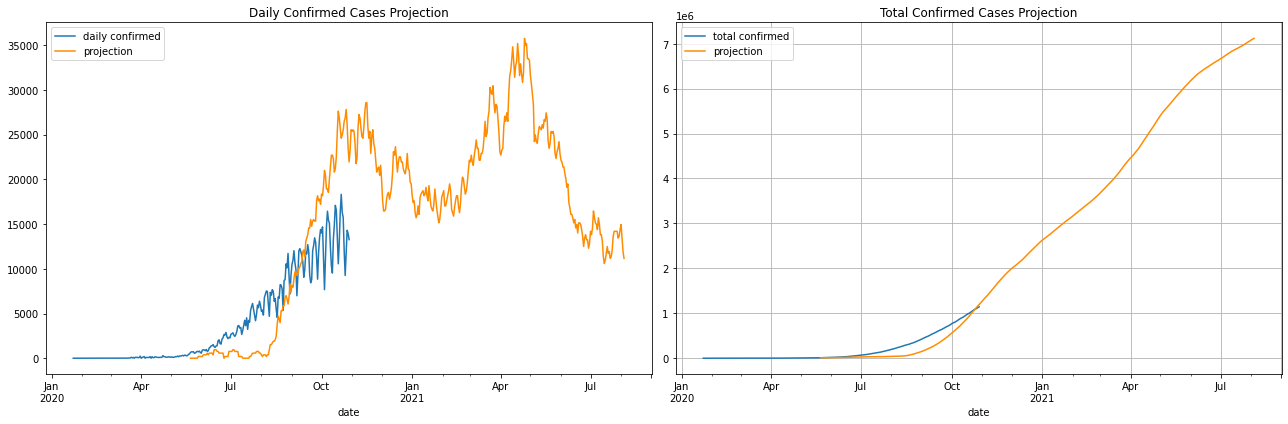



Simulation 2: using 50% end-to-end aggregated interventions:


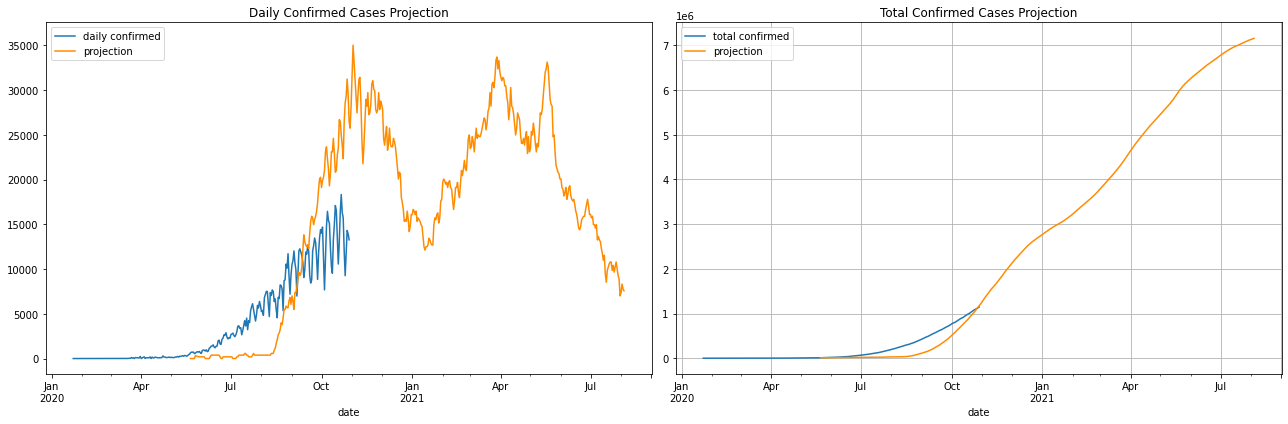



Simulation 3: using 90% end-to-end aggregated interventions:


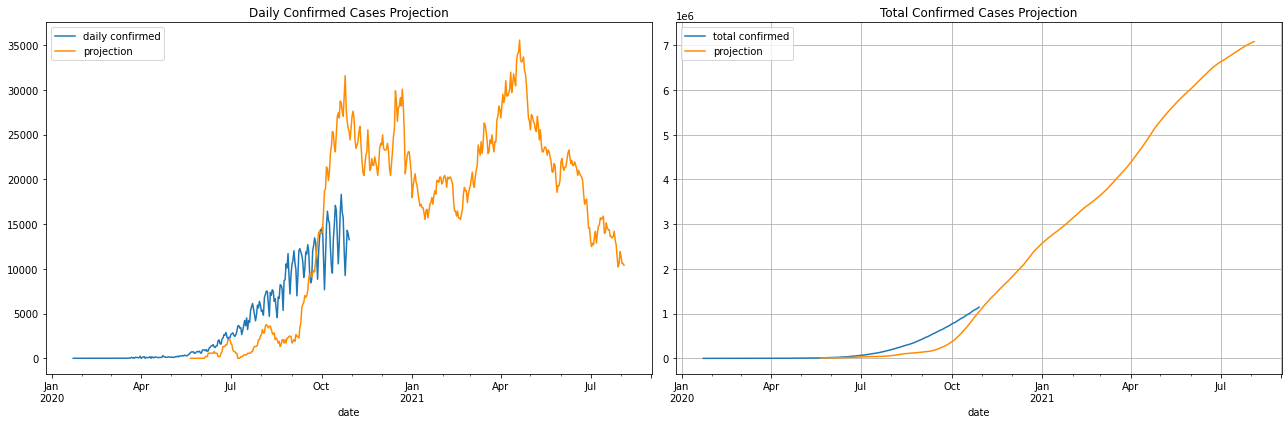

Total Time Taken: 0:08:05.814575


In [10]:
country_code, state, state_population, actual_testing_capacity = 'ARG', 'Argentina', 44044811, 4000
future_projection_days = 120

run (country_code, state, state_population, actual_testing_capacity, future_projection_days, country_level_projection=True)

Data Availability Timeline: 2020-01-23 00:00:00 to 2020-10-29 00:00:00
w1_start_dt: 2020-03-01 00:00:00 | w1_peak_dt: 2020-04-02 00:00:00 | w2_start_dt: 2020-08-01 00:00:00 | days_between_disease_waves: 185
Case Rt: 3583.5454545454545 [0.00603499277089192 %]  |  Init Case Rt: 773.5 [0.0013026392346618103 %]
Case Rate: 773.5, Incidence Rate: 9.304565961870074e-05, Projection Population: 3000, Scaling Factor: 35.825
Optimization params config: tranmission_control_range: (0.05, 1.0) | wave1_weeks_range: (4, 6) | n_calls: 40
[Real(low=0.05, high=1.0, prior='log-uniform', transform='identity')]

****************************************************************************************************
Learning Iterations # 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,
****************************************************************************************************
Lowest Error Observed: 94379277.60026222
Best Param(s): [0.5360051

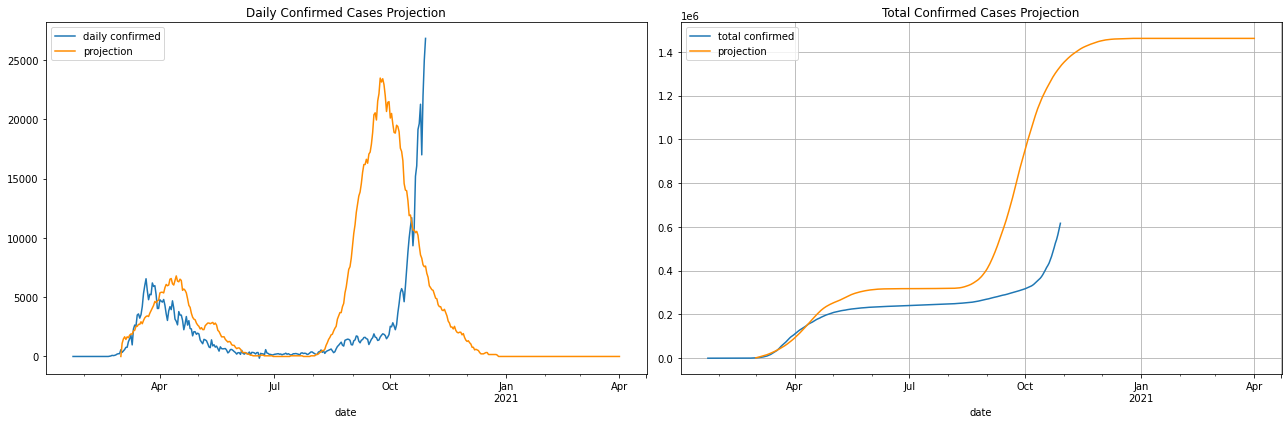



Simulation 2: using 50% end-to-end aggregated interventions:


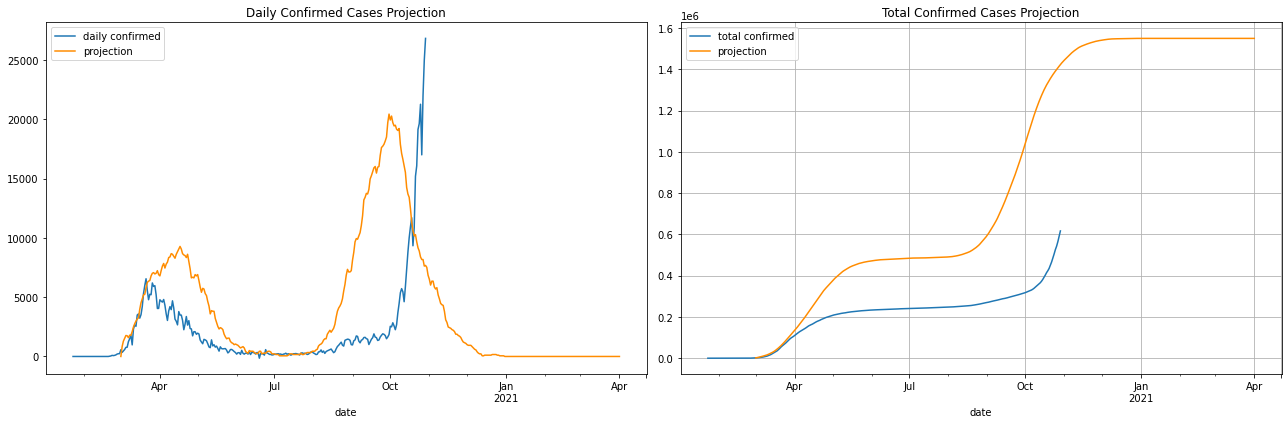



Simulation 3: using 90% end-to-end aggregated interventions:


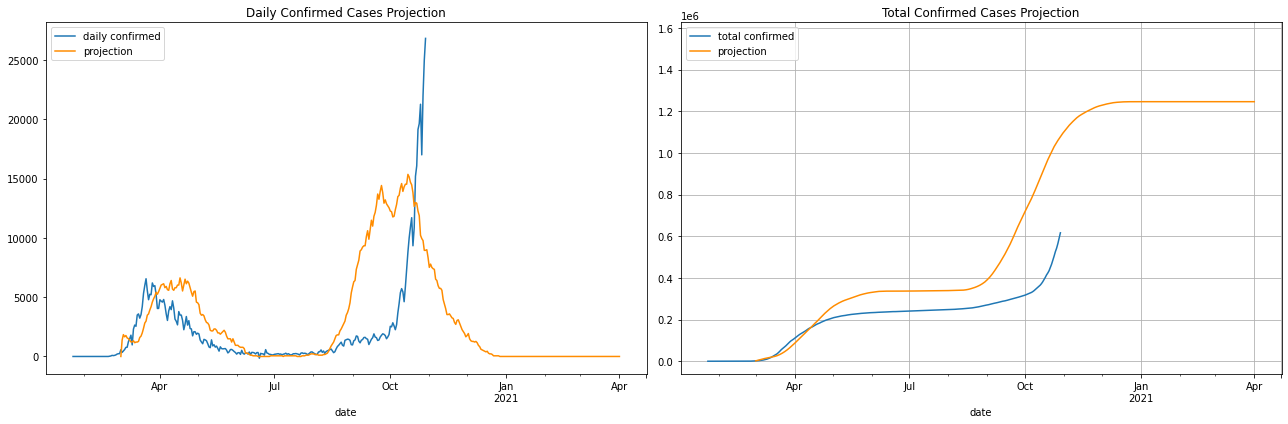

Total Time Taken: 0:04:46.750383


In [11]:
country_code, state, state_population, actual_testing_capacity = 'ITA', 'Italy', 59379449, 70000
future_projection_days = 90

run (country_code, state, state_population, actual_testing_capacity, future_projection_days, country_level_projection=True)

Data Availability Timeline: 2020-01-23 00:00:00 to 2020-10-29 00:00:00
w1_start_dt: 2020-03-13 00:00:00 | w1_peak_dt: 2020-04-08 00:00:00 | w2_start_dt: 2020-08-19 00:00:00 | days_between_disease_waves: 185
Case Rt: 2725.3888888888887 [0.0040759485822521955 %]  |  Init Case Rt: 1061.5 [0.0015875236879771021 %]
Case Rate: 1061.5, Incidence Rate: 0.00011339454914122156, Projection Population: 3000, Scaling Factor: 14.698
Optimization params config: tranmission_control_range: (0.05, 1.0) | wave1_weeks_range: (3, 5) | n_calls: 40
[Real(low=0.05, high=1.0, prior='log-uniform', transform='identity')]

****************************************************************************************************
Learning Iterations # 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,
****************************************************************************************************
Lowest Error Observed: 89637003.79602051
Best Param(s): [0.37

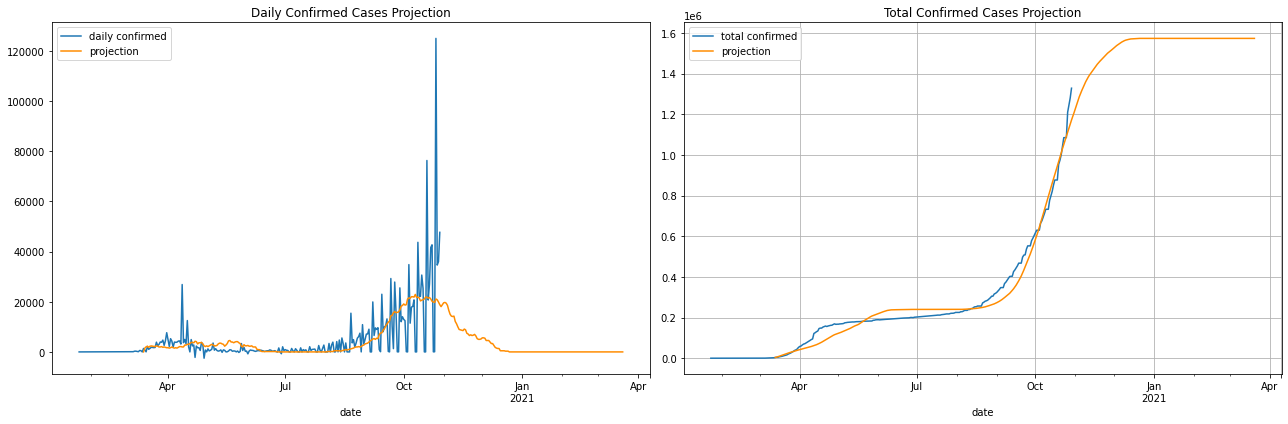



Simulation 2: using 50% end-to-end aggregated interventions:


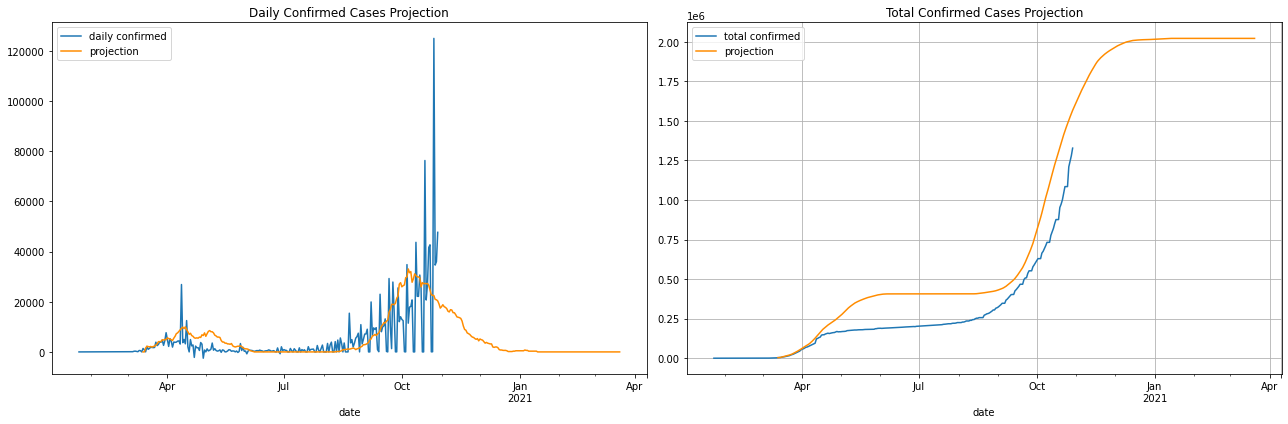



Simulation 3: using 90% end-to-end aggregated interventions:


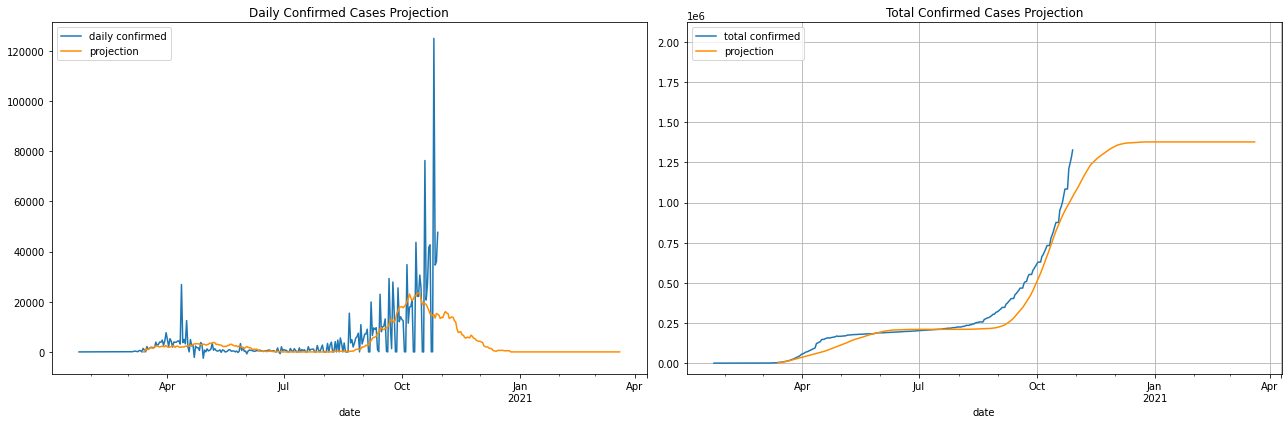

Total Time Taken: 0:03:20.320549


In [12]:
country_code, state, state_population, actual_testing_capacity = 'FRA', 'France', 66865144, 50000
future_projection_days = 90

run (country_code, state, state_population, actual_testing_capacity, future_projection_days, country_level_projection=True)

Data Availability Timeline: 2020-01-23 00:00:00 to 2020-10-29 00:00:00
w1_start_dt: 2020-03-13 00:00:00 | w1_peak_dt: 2020-04-11 00:00:00 | w2_start_dt: 2020-08-28 00:00:00 | days_between_disease_waves: 197
Case Rt: 943.65 [0.008425446428571428 %]  |  Init Case Rt: 208.95 [0.001865625 %]
Case Rate: 208.95, Incidence Rate: 0.00013325892857142855, Projection Population: 3000, Scaling Factor: 25.014
Optimization params config: tranmission_control_range: (0.05, 1.0) | wave1_weeks_range: (3, 5) | n_calls: 40
[Real(low=0.05, high=1.0, prior='log-uniform', transform='identity')]

****************************************************************************************************
Learning Iterations # 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,
****************************************************************************************************
Lowest Error Observed: 3167300.266440681
Best Param(s): [0.5643138226337922]


Best 

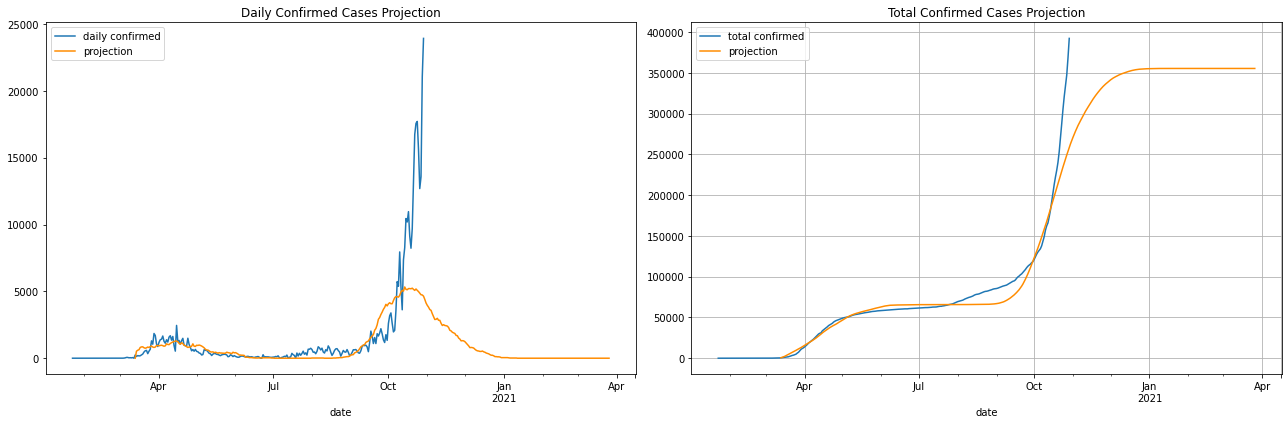



Simulation 2: using 50% end-to-end aggregated interventions:


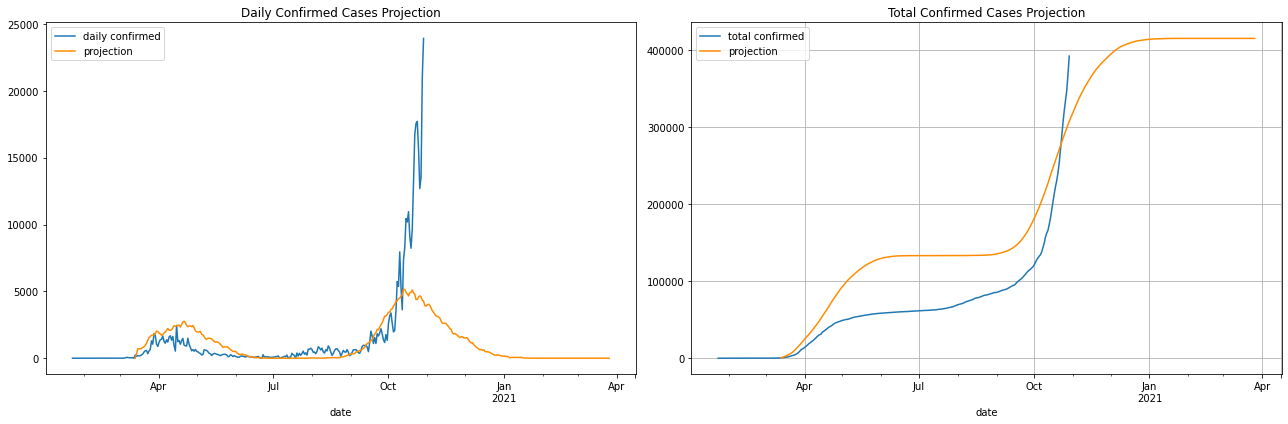



Simulation 3: using 90% end-to-end aggregated interventions:


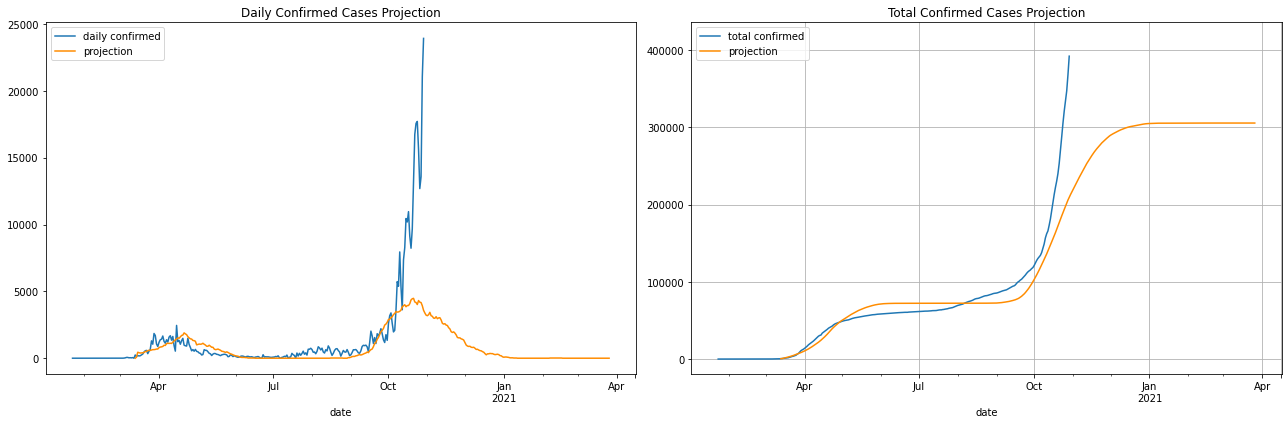

Total Time Taken: 0:04:22.343799


In [13]:
country_code, state, state_population, actual_testing_capacity = 'BEL', 'Belgium', 11200000, 50000
future_projection_days = 90

run (country_code, state, state_population, actual_testing_capacity, future_projection_days, country_level_projection=True)

Data Availability Timeline: 2020-01-23 00:00:00 to 2020-10-29 00:00:00
w1_start_dt: 2020-03-07 00:00:00 | w1_peak_dt: 2020-04-02 00:00:00 | w2_start_dt: None | days_between_disease_waves: None
Case Rt: 4071.3333333333335 [0.008812409812409813 %]  |  Init Case Rt: 290.1 [0.000627922077922078 %]
Case Rate: 290.1, Incidence Rate: 4.485157699443414e-05, Projection Population: 3000, Scaling Factor: 37.159666666666666
Optimization params config: tranmission_control_range: (0.05, 1.0) | wave1_weeks_range: (3, 5) | n_calls: 40
[Real(low=0.05, high=1.0, prior='log-uniform', transform='identity')]

****************************************************************************************************
Learning Iterations # 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,
****************************************************************************************************
Lowest Error Observed: 90346145.16125451
Best Param(s): [0.671291107

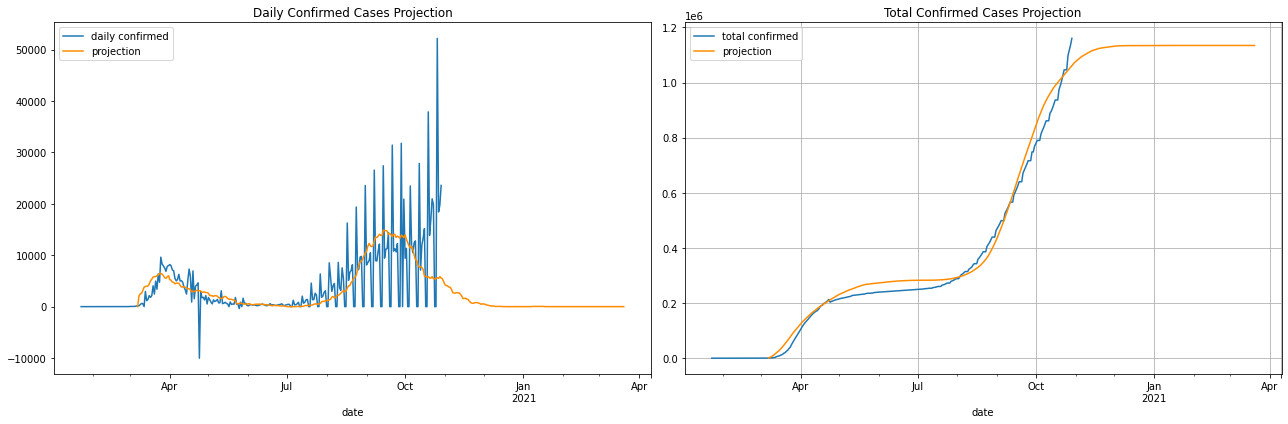



Simulation 2: using 50% end-to-end aggregated interventions:


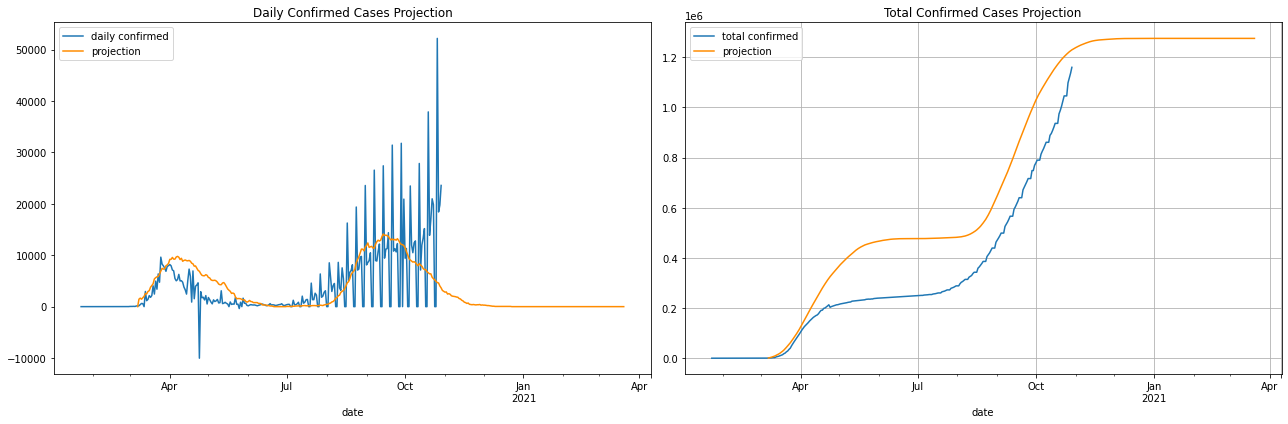



Simulation 3: using 90% end-to-end aggregated interventions:


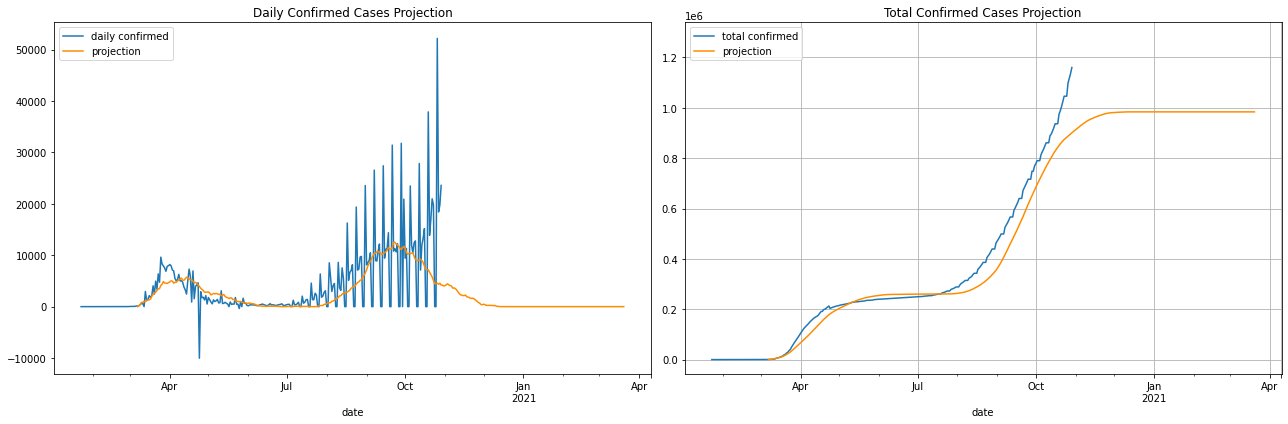

Total Time Taken: 0:04:30.254893


In [14]:
country_code, state, state_population, actual_testing_capacity = 'ESP', 'Spain', 46200000, 100000
future_projection_days = 90

run (country_code, state, state_population, actual_testing_capacity, future_projection_days, country_level_projection=True)

Data Availability Timeline: 2020-01-23 00:00:00 to 2020-10-29 00:00:00
w1_start_dt: 2020-03-13 00:00:00 | w1_peak_dt: 2020-04-17 00:00:00 | w2_start_dt: 2020-08-13 00:00:00 | days_between_disease_waves: 188
Case Rt: 3271.75 [0.005033461538461539 %]  |  Init Case Rt: 922.4 [0.001419076923076923 %]
Case Rate: 922.4, Incidence Rate: 0.00010136263736263735, Projection Population: 3000, Scaling Factor: 32.885333333333335
Optimization params config: tranmission_control_range: (0.05, 1.0) | wave1_weeks_range: (4, 6) | n_calls: 40
[Real(low=0.05, high=1.0, prior='log-uniform', transform='identity')]

****************************************************************************************************
Learning Iterations # 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,
****************************************************************************************************
Lowest Error Observed: 28170580.18440087
Best Param(s): [0.56367

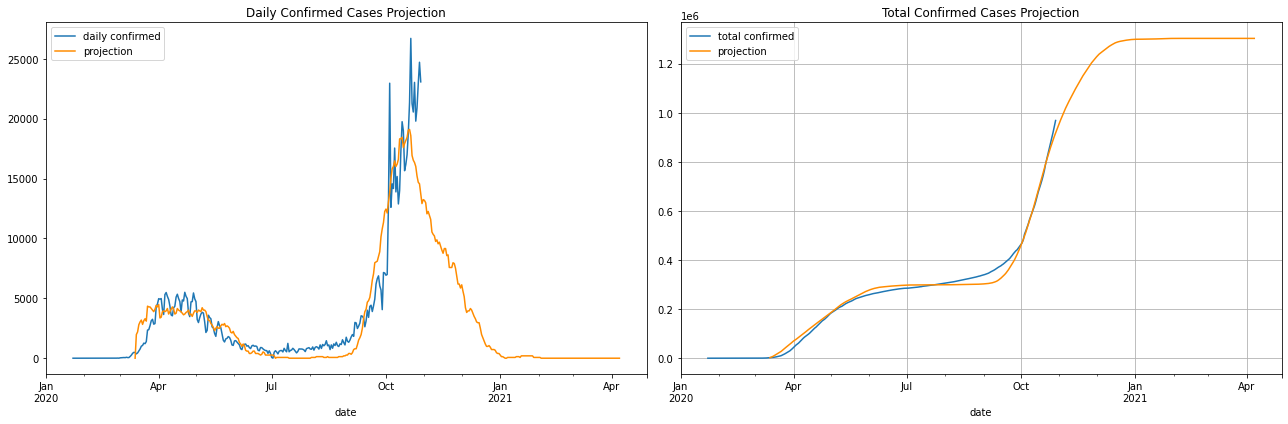



Simulation 2: using 50% end-to-end aggregated interventions:


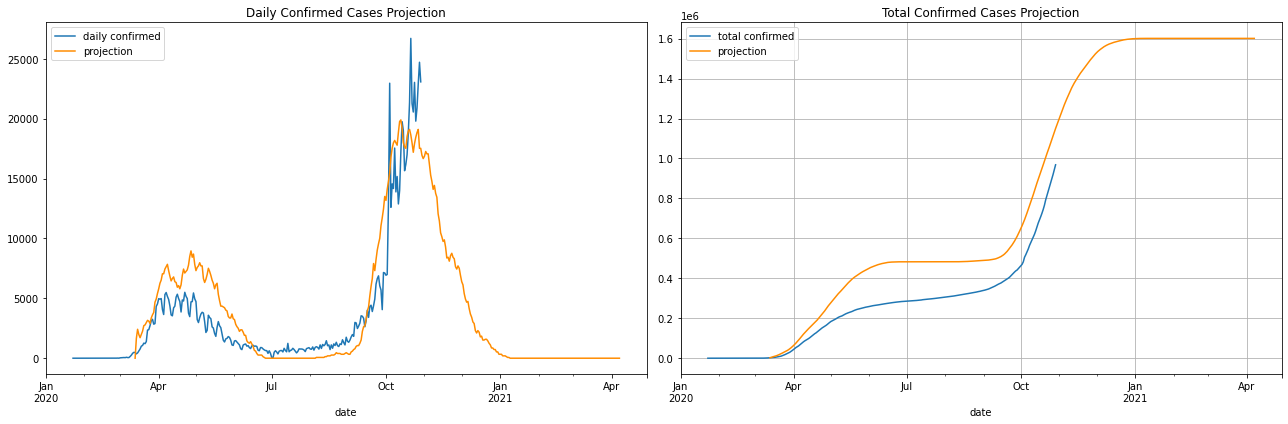



Simulation 3: using 90% end-to-end aggregated interventions:


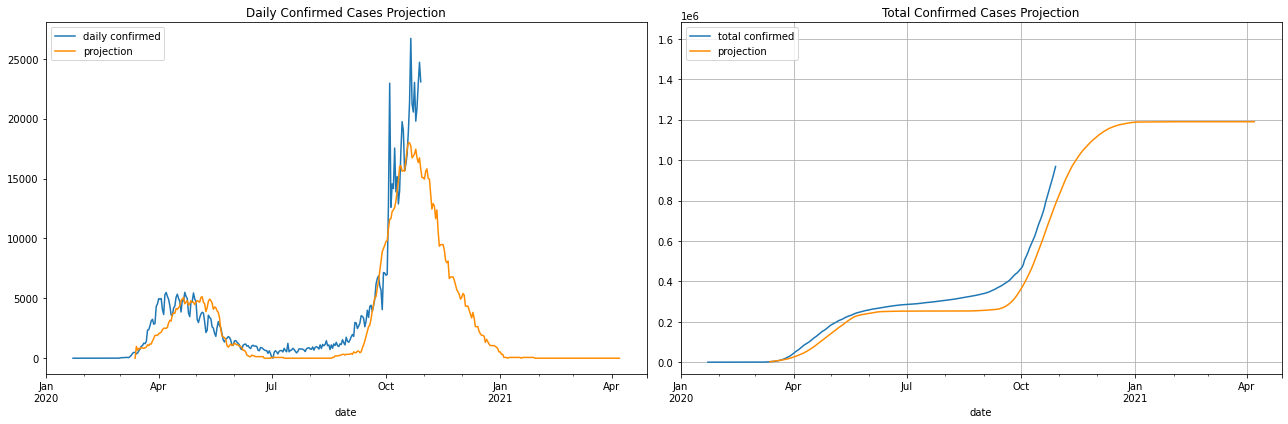

Total Time Taken: 0:04:42.297233


In [15]:
country_code, state, state_population, actual_testing_capacity = 'GBR', 'United Kingdom', 65000000, 120000
future_projection_days = 90

run (country_code, state, state_population, actual_testing_capacity, future_projection_days, country_level_projection=True)

Data Availability Timeline: 2020-01-23 00:00:00 to 2020-10-29 00:00:00
w1_start_dt: 2020-03-04 00:00:00 | w1_peak_dt: 2020-03-30 00:00:00 | w2_start_dt: 2020-06-17 00:00:00 | days_between_disease_waves: 120
Case Rt: 151.66666666666666 [0.0006319444444444444 %]  |  Init Case Rt: 9.2 [3.833333333333333e-05 %]
Case Rate: 9.2, Incidence Rate: 2.7380952380952374e-06, Projection Population: 3000, Scaling Factor: 608.6956666666666
Optimization params config: tranmission_control_range: (0.05, 1.0) | wave1_weeks_range: (3, 5) | n_calls: 40
[Real(low=0.05, high=1.0, prior='log-uniform', transform='identity')]

****************************************************************************************************
Learning Iterations # 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,
****************************************************************************************************
Lowest Error Observed: 3358721.2615708634
Best Param(s):

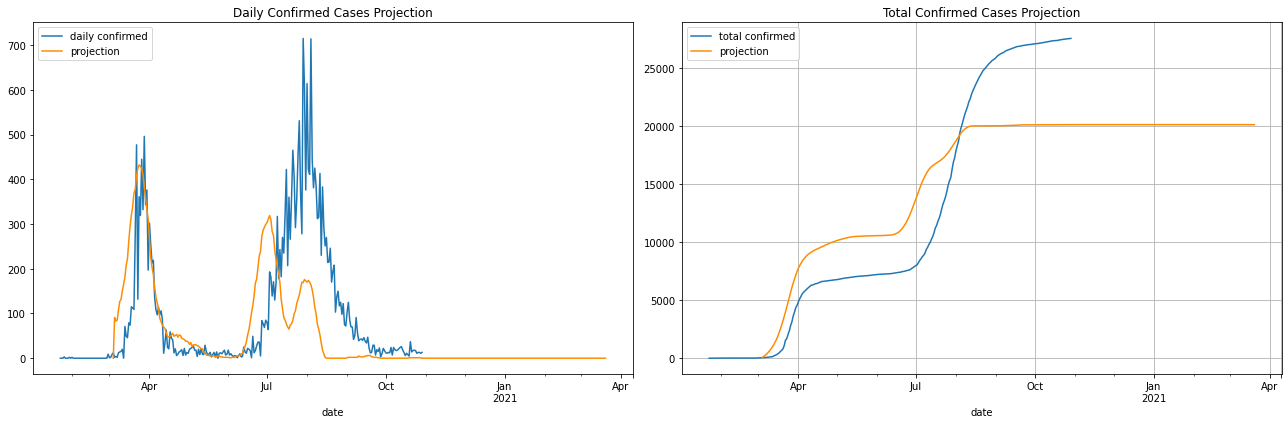



Simulation 2: using 50% end-to-end aggregated interventions:


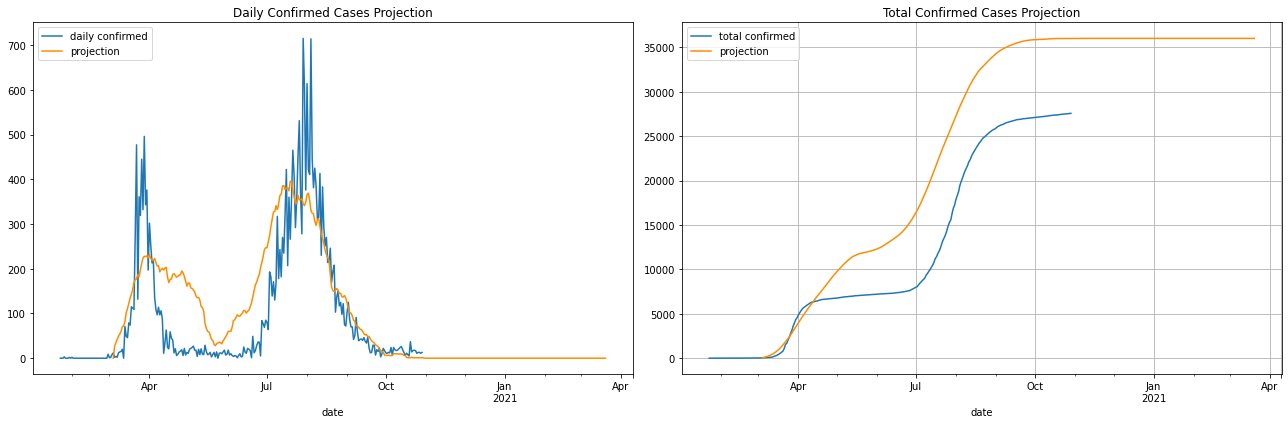



Simulation 3: using 90% end-to-end aggregated interventions:


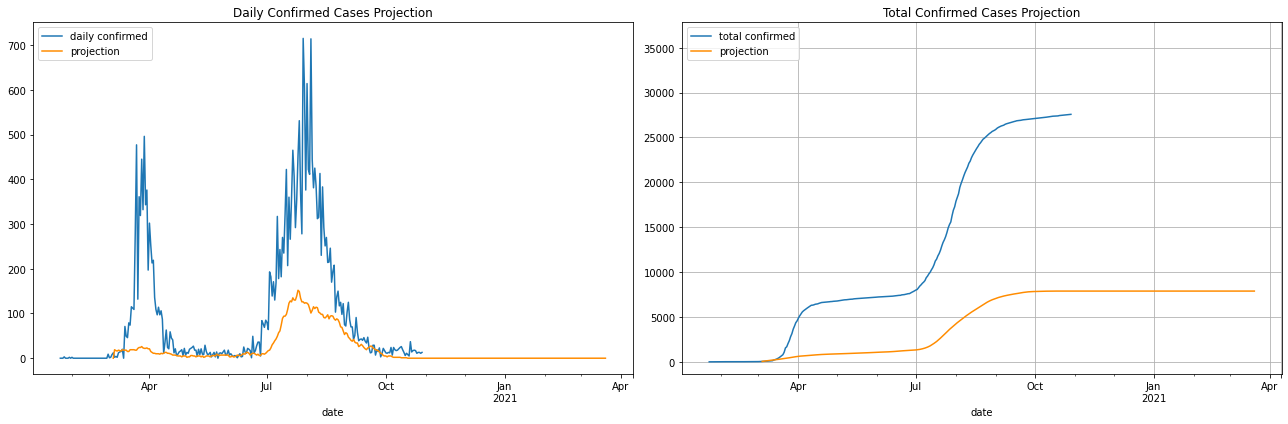

Total Time Taken: 0:04:45.667956


In [16]:
country_code, state, state_population, actual_testing_capacity = 'AUS', 'Australia', 24000000, 70000
future_projection_days = 90

run (country_code, state, state_population, actual_testing_capacity, future_projection_days, country_level_projection=True)

Data Availability Timeline: 2020-01-23 00:00:00 to 2020-10-29 00:00:00
w1_start_dt: 2020-06-14 00:00:00 | w1_peak_dt: 2020-09-23 00:00:00 | w2_start_dt: None | days_between_disease_waves: None
Case Rt: 1895.7941176470588 [0.022303460207612456 %]  |  Init Case Rt: 454.05 [0.005341764705882353 %]
Case Rate: 454.05, Incidence Rate: 0.0003815546218487394, Projection Population: 3000, Scaling Factor: 8.736333333333333
Optimization params config: tranmission_control_range: (0.05, 1.0) | wave1_weeks_range: (13, 15) | n_calls: 40
[Real(low=0.05, high=1.0, prior='log-uniform', transform='identity')]

****************************************************************************************************
Learning Iterations # 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,
****************************************************************************************************
Lowest Error Observed: 722171790.7486962
Best Param(s): [0.535875

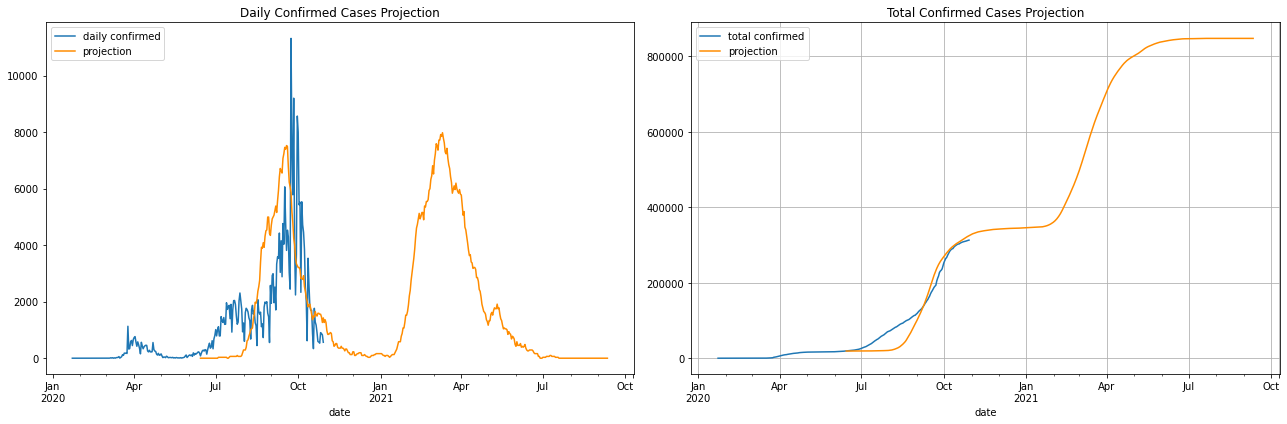



Simulation 2: using 50% end-to-end aggregated interventions:


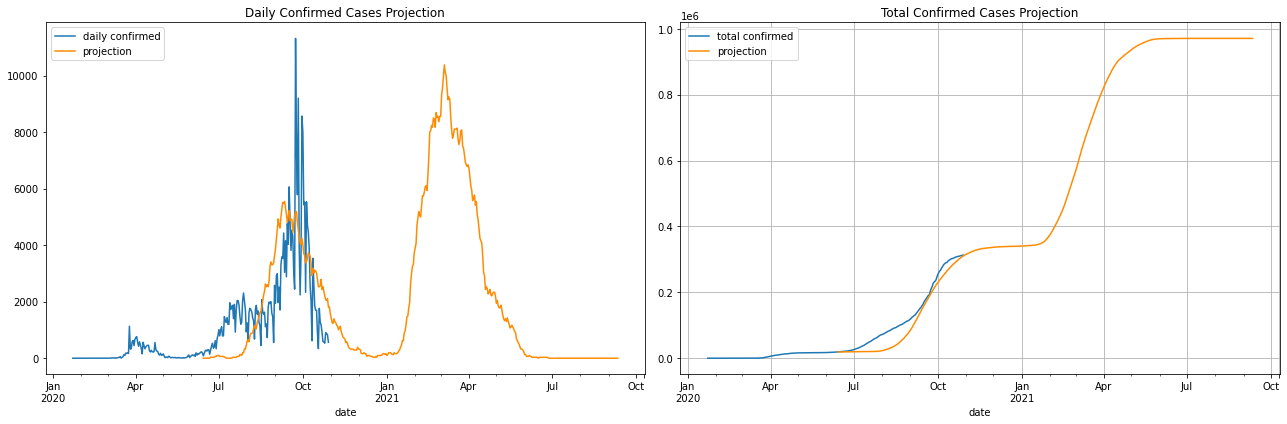



Simulation 3: using 90% end-to-end aggregated interventions:


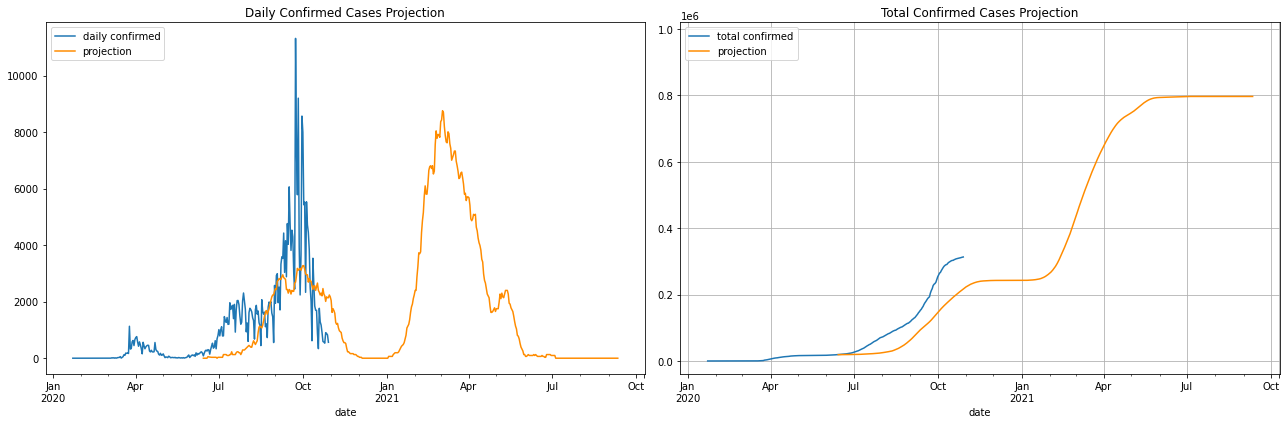

Total Time Taken: 0:08:30.786975


In [17]:
country_code, state, state_population, actual_testing_capacity = 'ISR', 'Israel', 8500000, 30000
future_projection_days = 180

run (country_code, state, state_population, actual_testing_capacity, future_projection_days, country_level_projection=True)

Data Availability Timeline: 2020-01-23 00:00:00 to 2020-10-29 00:00:00
w1_start_dt: 2020-03-13 00:00:00 | w1_peak_dt: 2020-04-14 00:00:00 | w2_start_dt: 2020-06-20 00:00:00 | days_between_disease_waves: 114
Case Rt: 236.6818181818182 [0.00018934545454545455 %]  |  Init Case Rt: 45.5 [3.64e-05 %]
Case Rate: 45.5, Incidence Rate: 2.5999999999999997e-06, Projection Population: 3000, Scaling Factor: 1282.0513333333333
Optimization params config: tranmission_control_range: (0.05, 1.0) | wave1_weeks_range: (4, 6) | n_calls: 40
[Real(low=0.05, high=1.0, prior='log-uniform', transform='identity')]

****************************************************************************************************
Learning Iterations # 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,
****************************************************************************************************
Lowest Error Observed: 753154.5137989509
Best Param(s): [0.5969464

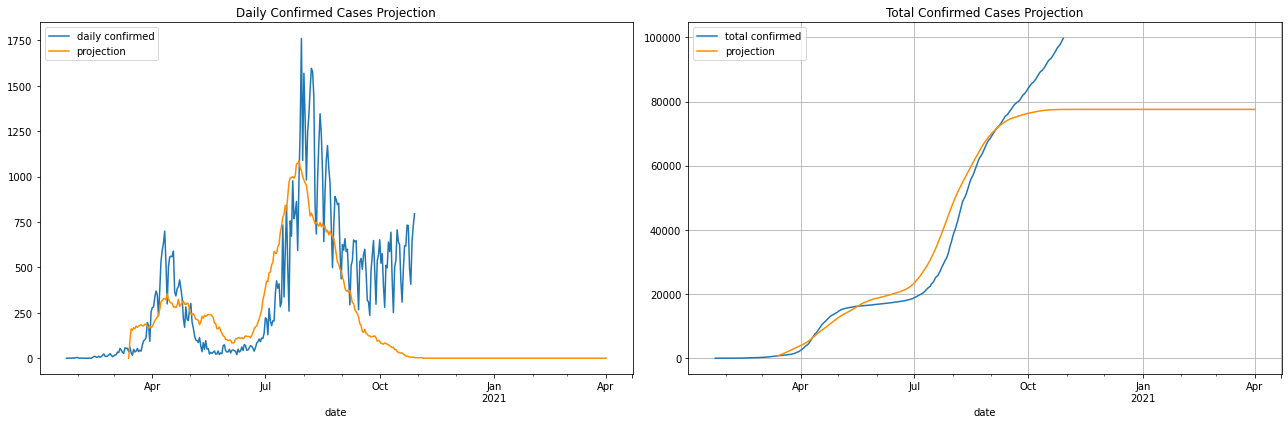



Simulation 2: using 50% end-to-end aggregated interventions:


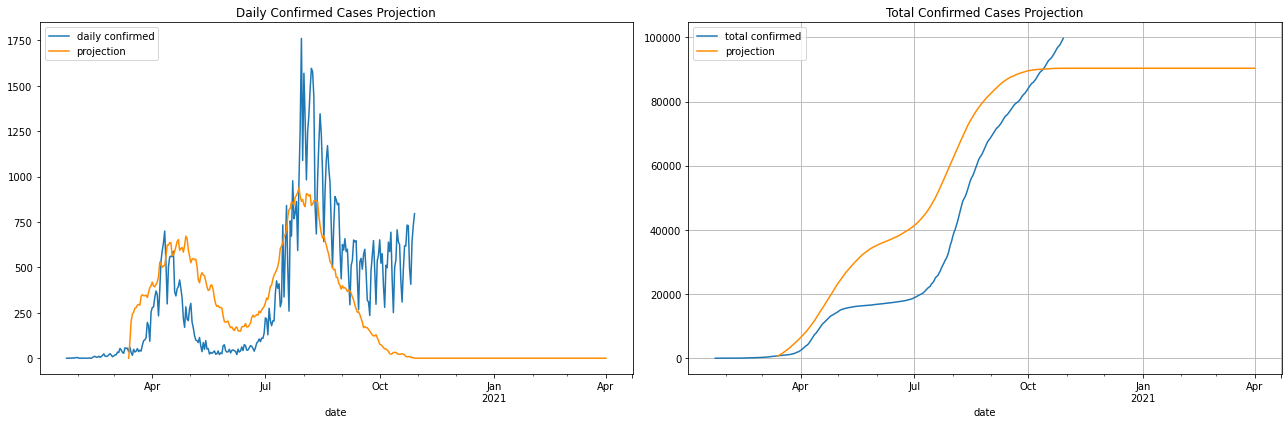



Simulation 3: using 90% end-to-end aggregated interventions:


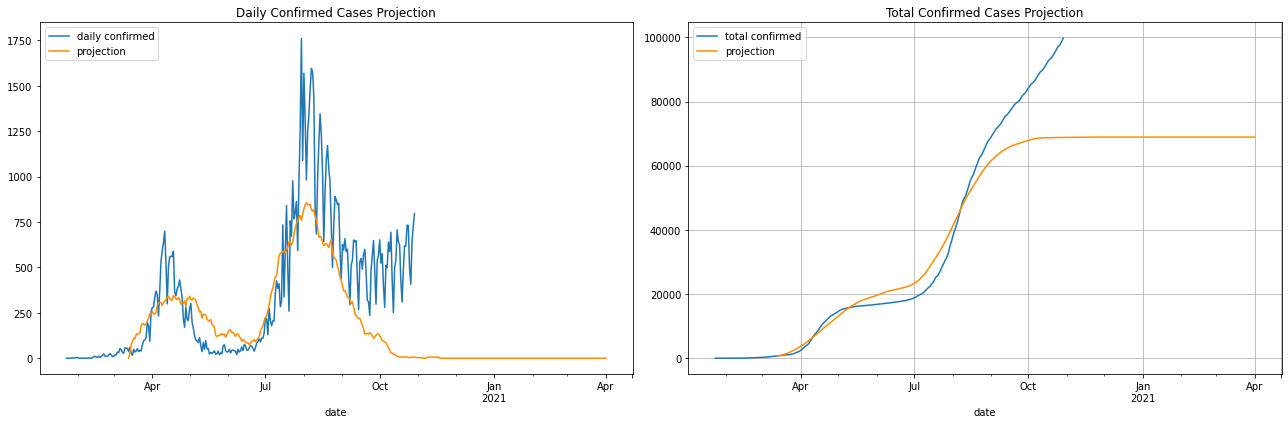

Total Time Taken: 0:05:07.479251


In [18]:
country_code, state, state_population, actual_testing_capacity = 'JPN', 'Japan', 125000000, 150000
future_projection_days = 90

run (country_code, state, state_population, actual_testing_capacity, future_projection_days, country_level_projection=True)

Data Availability Timeline: 2020-01-23 00:00:00 to 2020-10-29 00:00:00
w1_start_dt: 2020-04-30 00:00:00 | w1_peak_dt: 2020-09-17 00:00:00 | w2_start_dt: None | days_between_disease_waves: None
Case Rt: 37312.27659574468 [0.002870175122749591 %]  |  Init Case Rt: 4566.200000000001 [0.0003512461538461539 %]
Case Rate: 4566.200000000001, Incidence Rate: 2.508901098901099e-05, Projection Population: 3000, Scaling Factor: 79.71633333333334
Optimization params config: tranmission_control_range: (0.05, 1.0) | wave1_weeks_range: (19, 21) | n_calls: 40
[Real(low=0.05, high=1.0, prior='log-uniform', transform='identity')]

****************************************************************************************************
Learning Iterations # 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,
****************************************************************************************************
Lowest Error Observed: 52257650275.228615
B

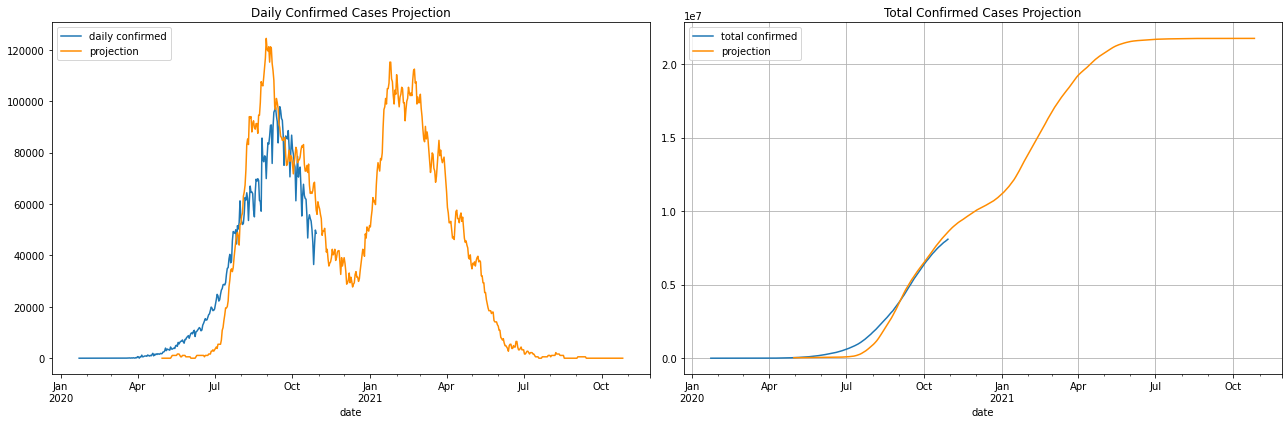



Simulation 2: using 50% end-to-end aggregated interventions:


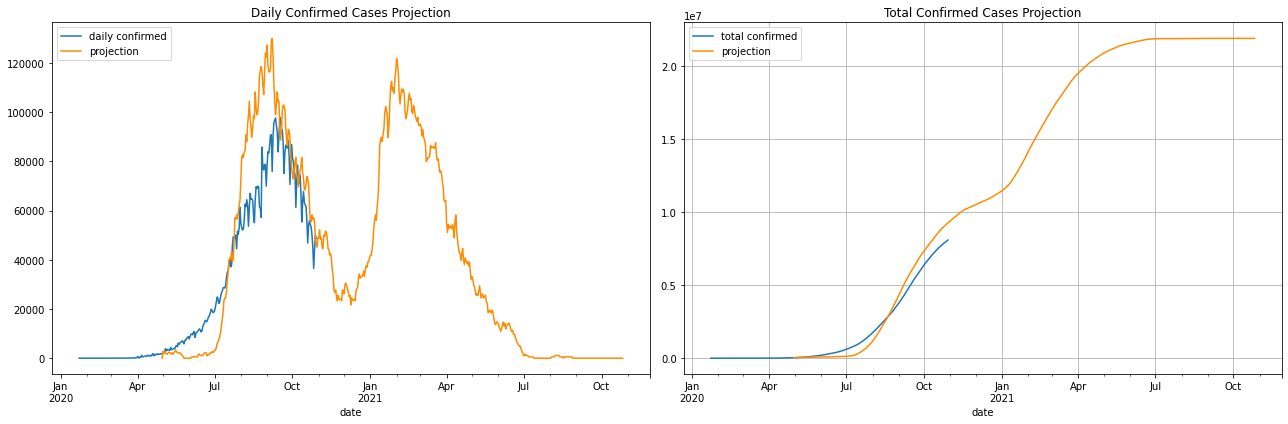



Simulation 3: using 90% end-to-end aggregated interventions:


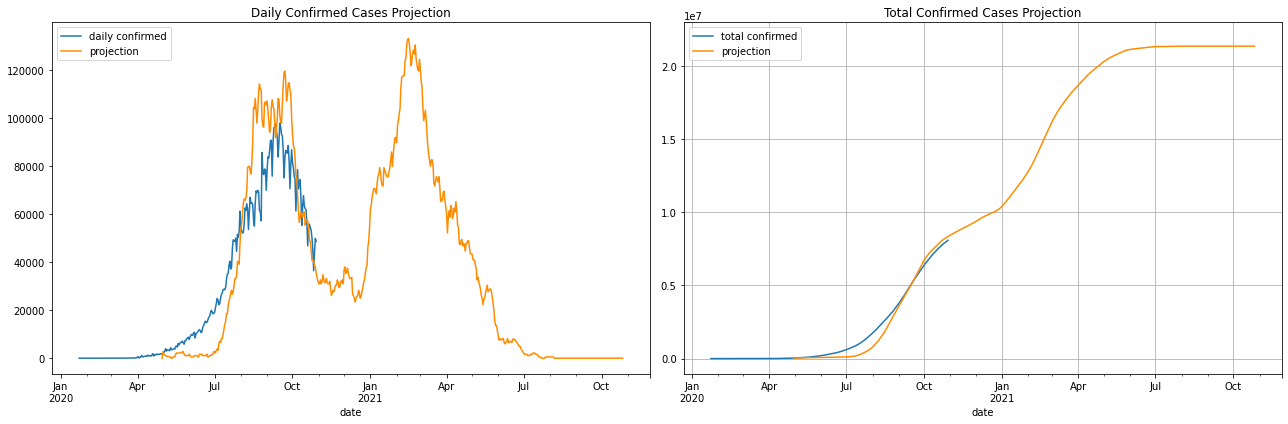

Total Time Taken: 0:11:16.746614


In [19]:
country_code, state, state_population, actual_testing_capacity = 'IND', 'India', 1300000000, 500000
future_projection_days = 180
init_infection = 3 #w.r.t. the configured simulation population size

run (country_code, state, state_population, actual_testing_capacity, future_projection_days, 
     country_level_projection=True, min_initial_infection = init_infection)

Data Availability Timeline: 2020-01-23 00:00:00 to 2020-10-29 00:00:00
w1_start_dt: 2020-05-30 00:00:00 | w1_peak_dt: 2020-08-18 00:00:00 | w2_start_dt: None | days_between_disease_waves: None
Case Rt: 1867.1851851851852 [0.0017782716049382715 %]  |  Init Case Rt: 617.4 [0.000588 %]
Case Rate: 617.4, Incidence Rate: 4.199999999999999e-05, Projection Population: 3000, Scaling Factor: 79.36533333333334
Optimization params config: tranmission_control_range: (0.05, 1.0) | wave1_weeks_range: (10, 12) | n_calls: 40
[Real(low=0.05, high=1.0, prior='log-uniform', transform='identity')]

****************************************************************************************************
Learning Iterations # 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,
****************************************************************************************************
Lowest Error Observed: 366043225.1489345
Best Param(s): [0.19992184032901755]


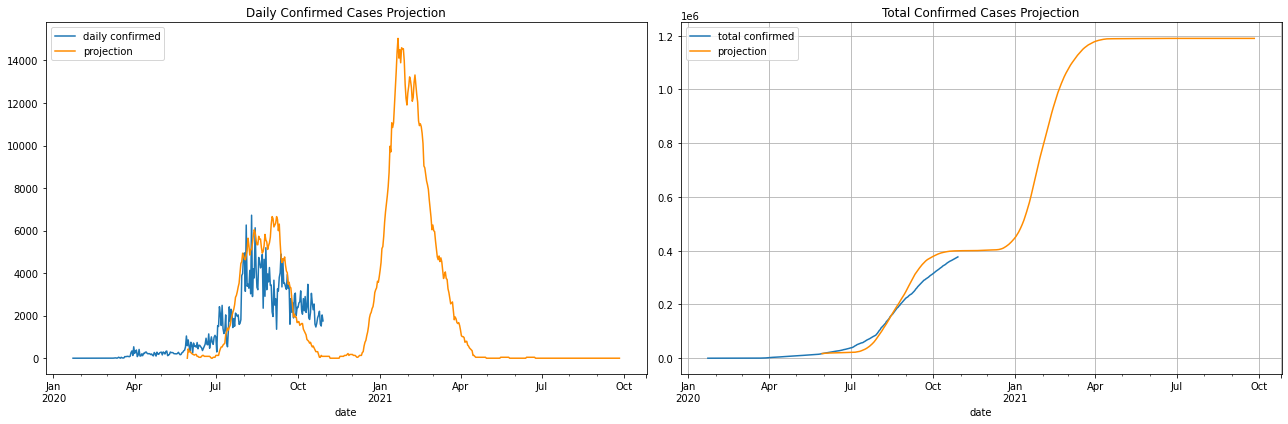



Simulation 2: using 50% end-to-end aggregated interventions:


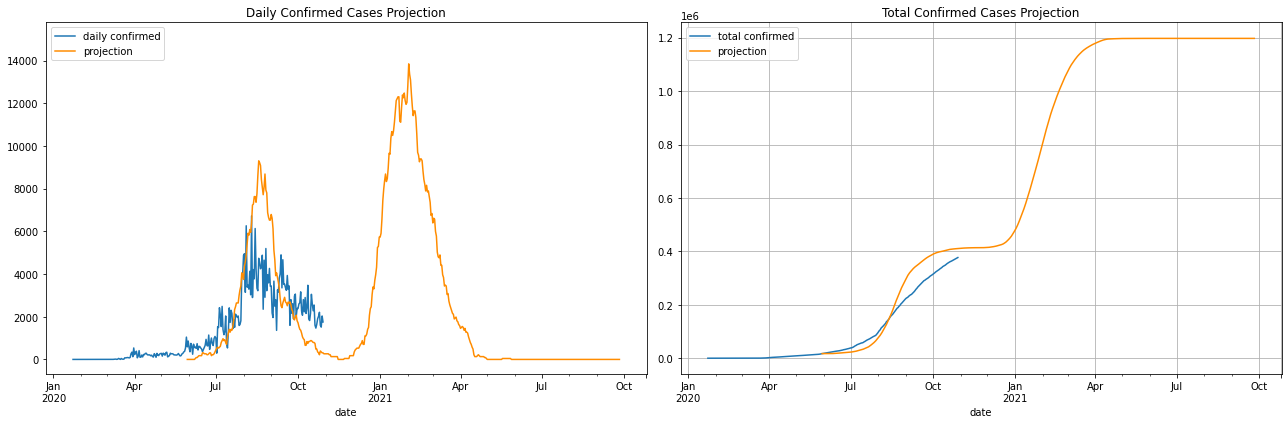



Simulation 3: using 90% end-to-end aggregated interventions:


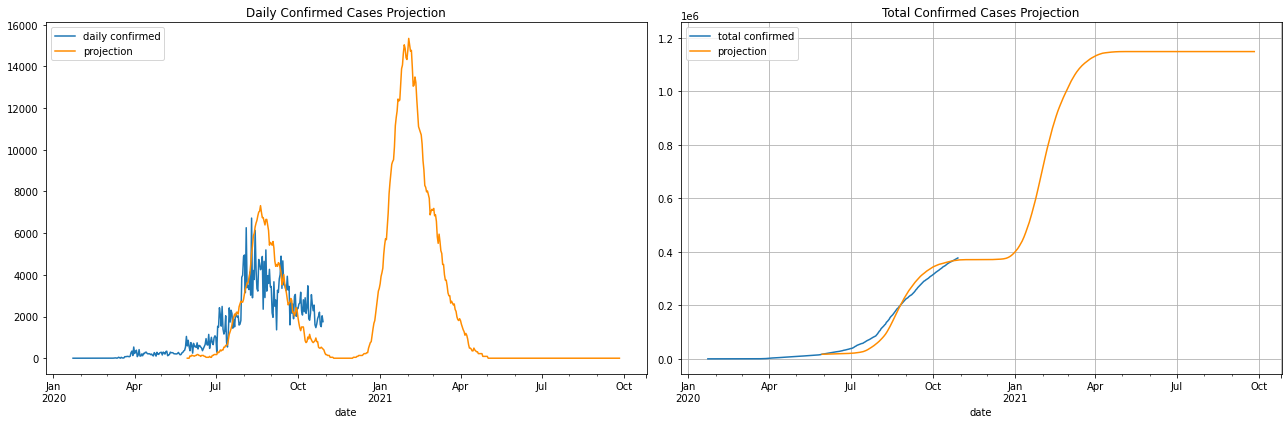

Total Time Taken: 0:08:49.995242


In [20]:
country_code, state, state_population, actual_testing_capacity = 'PHL', 'Philippines', 105000000, 90000
future_projection_days = 180

run (country_code, state, state_population, actual_testing_capacity, future_projection_days, country_level_projection=True)

Data Availability Timeline: 2020-01-23 00:00:00 to 2020-10-29 00:00:00
w1_start_dt: 2020-03-28 00:00:00 | w1_peak_dt: 2020-05-29 00:00:00 | w2_start_dt: None | days_between_disease_waves: None
Case Rt: 863.5952380952381 [0.031985008818342146 %]  |  Init Case Rt: 176.0 [0.006518518518518518 %]
Case Rate: 176.0, Incidence Rate: 0.00026074074074074075, Projection Population: 3000, Scaling Factor: 12.784333333333333
Optimization params config: tranmission_control_range: (0.05, 1.0) | wave1_weeks_range: (8, 10) | n_calls: 40
[Real(low=0.05, high=1.0, prior='log-uniform', transform='identity')]

****************************************************************************************************
Learning Iterations # 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,
****************************************************************************************************
Lowest Error Observed: 901986.9082537484
Best Param(s): [0.35036665

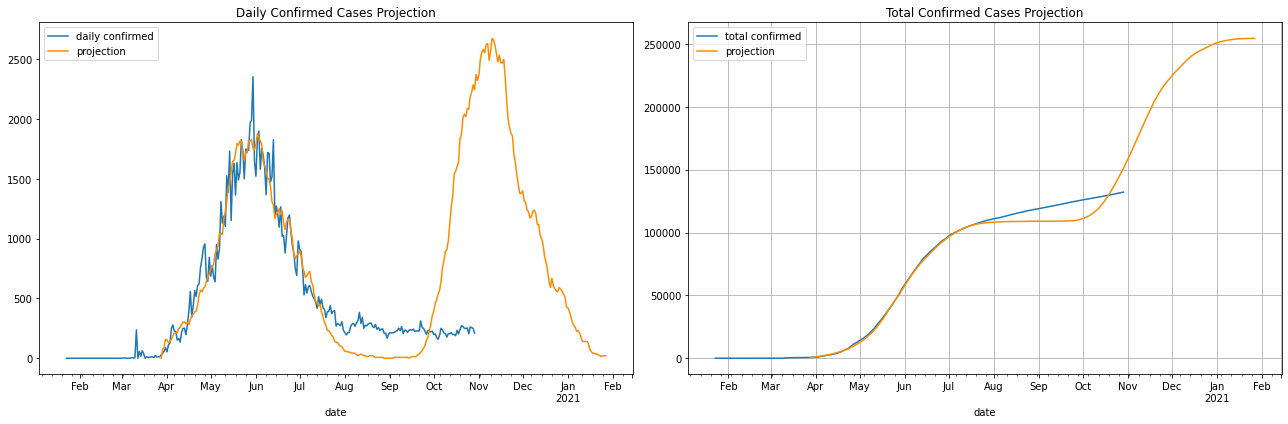



Simulation 2: using 50% end-to-end aggregated interventions:


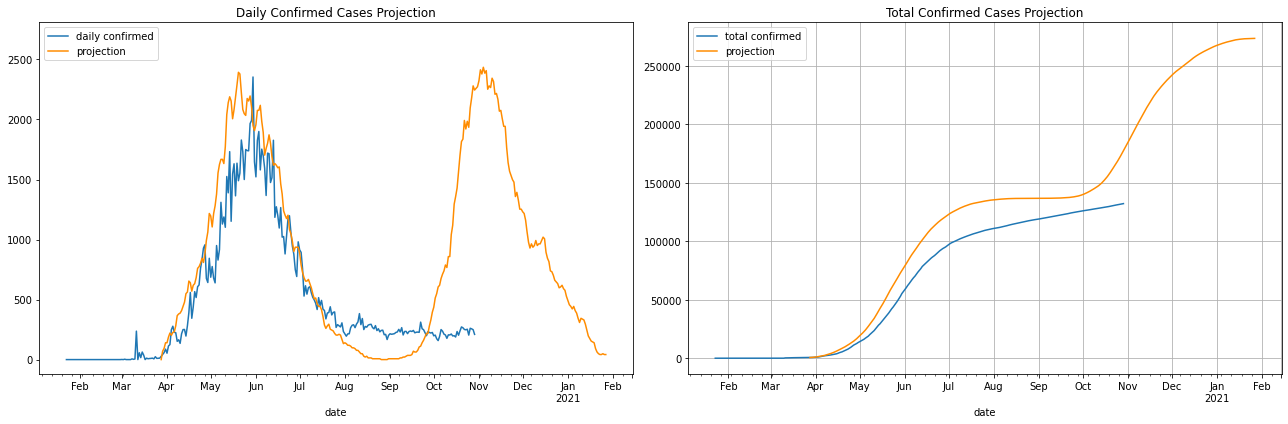



Simulation 3: using 90% end-to-end aggregated interventions:


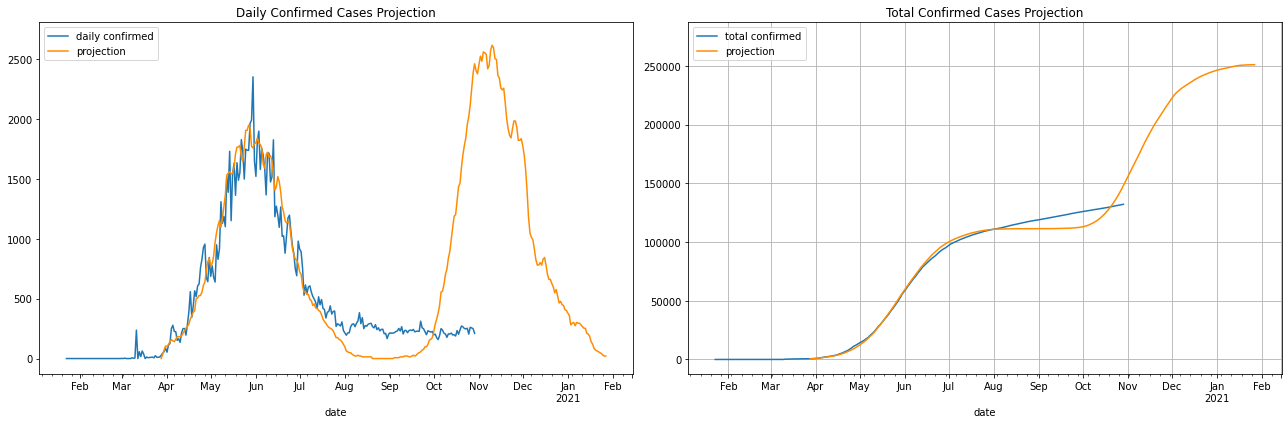

Total Time Taken: 0:09:04.162019


In [2]:
country_code, state, state_population, actual_testing_capacity = 'QAT', 'Qatar', 2700000, 10000
future_projection_days = 90

run (country_code, state, state_population, actual_testing_capacity, future_projection_days, country_level_projection=True)

Data Availability Timeline: 2020-01-23 00:00:00 to 2020-10-29 00:00:00
w1_start_dt: 2020-04-06 00:00:00 | w1_peak_dt: 2020-05-17 00:00:00 | w2_start_dt: 2020-08-31 00:00:00 | days_between_disease_waves: 188
Case Rt: 6617.75 [0.004726964285714286 %]  |  Init Case Rt: 2008.35 [0.0014345357142857144 %]
Case Rate: 2008.35, Incidence Rate: 0.00010246683673469387, Projection Population: 3000, Scaling Factor: 32.531
Optimization params config: tranmission_control_range: (0.05, 1.0) | wave1_weeks_range: (5, 7) | n_calls: 40
[Real(low=0.05, high=1.0, prior='log-uniform', transform='identity')]

****************************************************************************************************
Learning Iterations # 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,
****************************************************************************************************
Lowest Error Observed: 393926983.1042193
Best Param(s): [0.426058844847

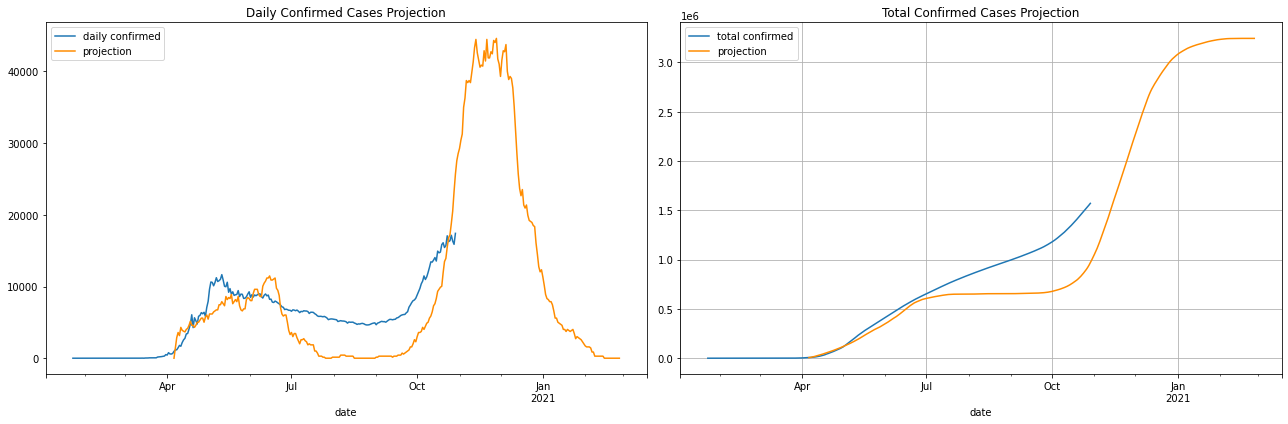



Simulation 2: using 50% end-to-end aggregated interventions:


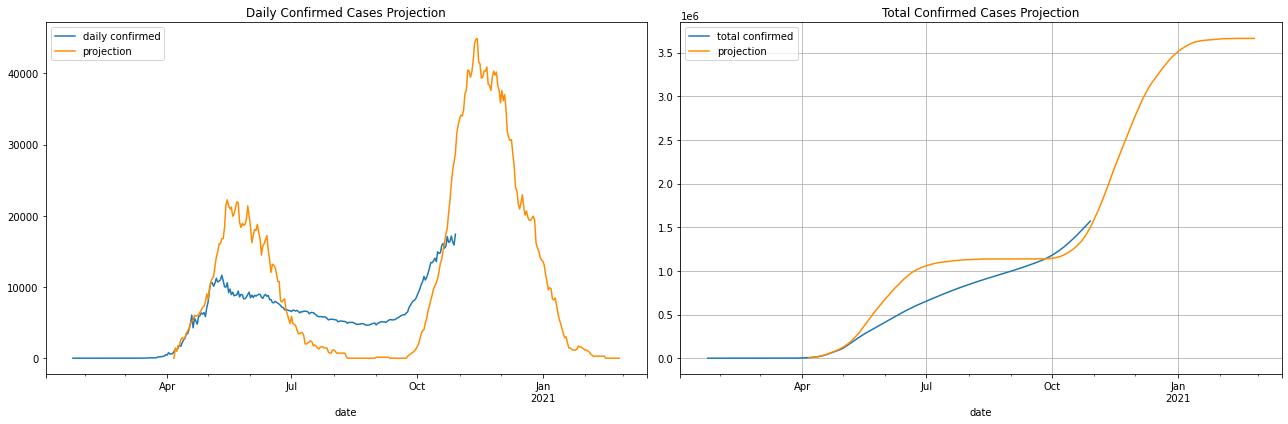



Simulation 3: using 90% end-to-end aggregated interventions:


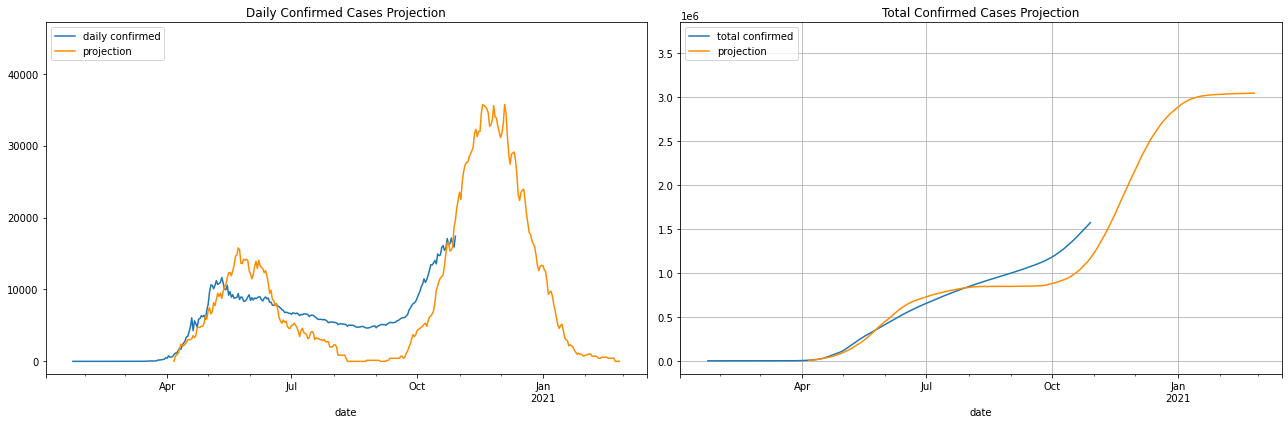

Total Time Taken: 0:05:15.361466


In [3]:
country_code, state, state_population, actual_testing_capacity = 'RUS', 'Russia', 140000000, 150000
future_projection_days = 120

run (country_code, state, state_population, actual_testing_capacity, future_projection_days, country_level_projection=True)

Data Availability Timeline: 2020-01-23 00:00:00 to 2020-10-29 00:00:00
w1_start_dt: 2020-04-06 00:00:00 | w1_peak_dt: 2020-06-25 00:00:00 | w2_start_dt: None | days_between_disease_waves: None
Case Rt: 2088.037037037037 [0.006327384960718294 %]  |  Init Case Rt: 565.4 [0.0017133333333333334 %]
Case Rate: 565.4, Incidence Rate: 0.00012238095238095237, Projection Population: 3000, Scaling Factor: 27.237666666666666
Optimization params config: tranmission_control_range: (0.05, 1.0) | wave1_weeks_range: (10, 12) | n_calls: 40
[Real(low=0.05, high=1.0, prior='log-uniform', transform='identity')]

****************************************************************************************************
Learning Iterations # 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,
****************************************************************************************************
Lowest Error Observed: 839419572.7079678
Best Param(s): [0.286152

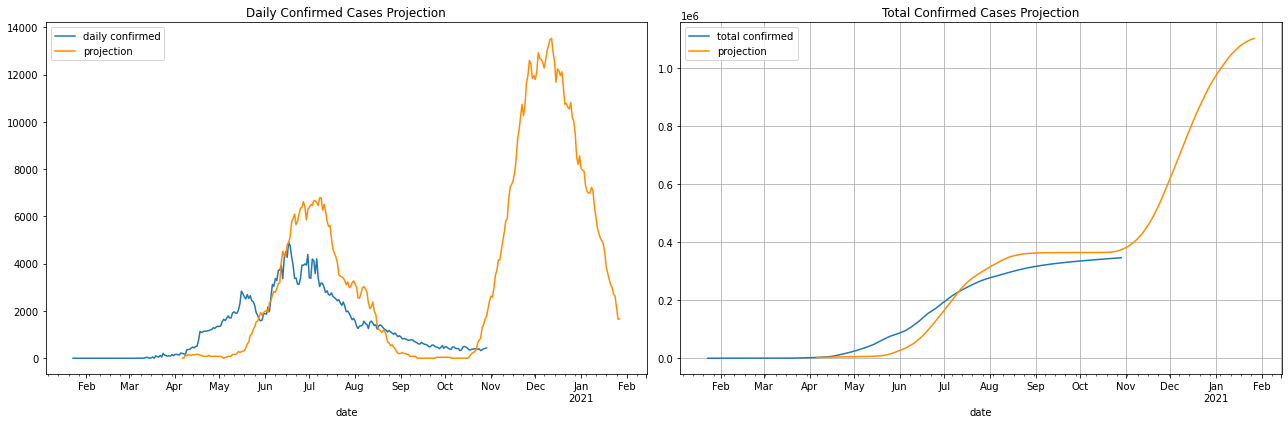



Simulation 2: using 50% end-to-end aggregated interventions:


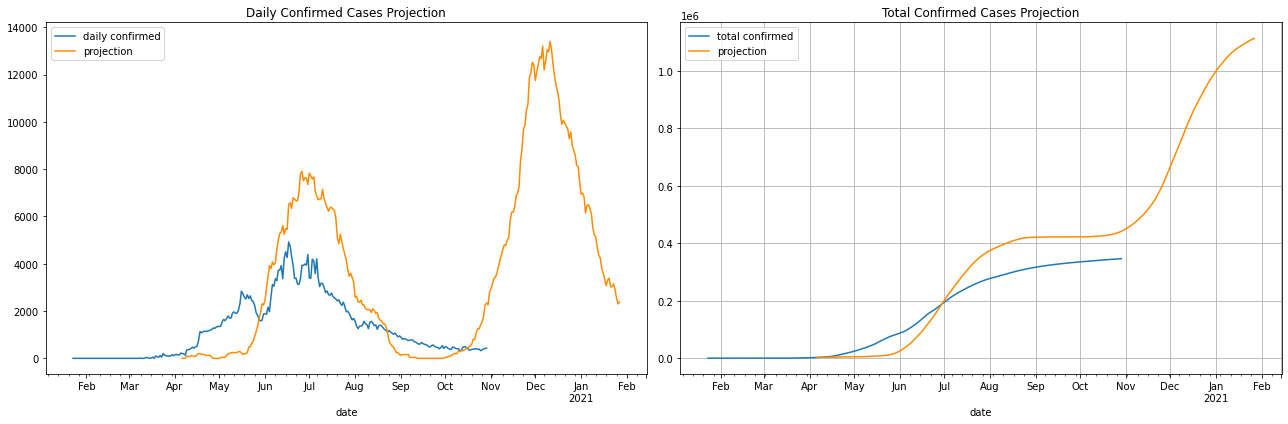



Simulation 3: using 90% end-to-end aggregated interventions:


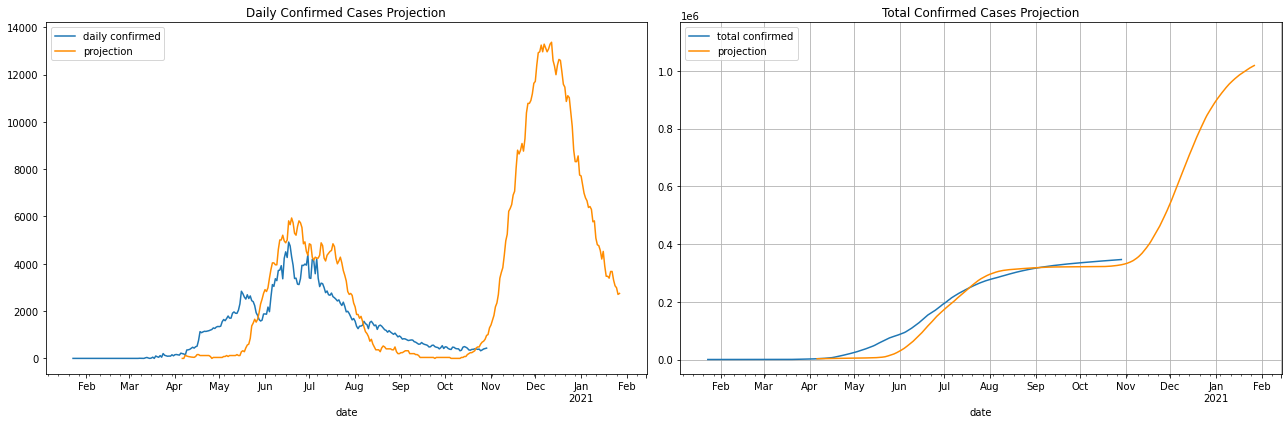

Total Time Taken: 0:08:34.347199


In [4]:
country_code, state, state_population, actual_testing_capacity = 'SAU', 'Saudi Arabia', 33000000, 90000
future_projection_days = 90

run (country_code, state, state_population, actual_testing_capacity, future_projection_days, country_level_projection=True)

Data Availability Timeline: 2020-01-23 00:00:00 to 2020-10-29 00:00:00
w1_start_dt: 2020-04-30 00:00:00 | w1_peak_dt: 2020-07-16 00:00:00 | w2_start_dt: None | days_between_disease_waves: None
Case Rt: 4208.461538461538 [0.007383265856950067 %]  |  Init Case Rt: 579.75 [0.0010171052631578947 %]
Case Rate: 579.75, Incidence Rate: 7.265037593984961e-05, Projection Population: 3000, Scaling Factor: 45.882
Optimization params config: tranmission_control_range: (0.05, 1.0) | wave1_weeks_range: (10, 12) | n_calls: 40
[Real(low=0.05, high=1.0, prior='log-uniform', transform='identity')]

****************************************************************************************************
Learning Iterations # 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,
****************************************************************************************************
Lowest Error Observed: 85756686.38528214
Best Param(s): [0.22646989464822312

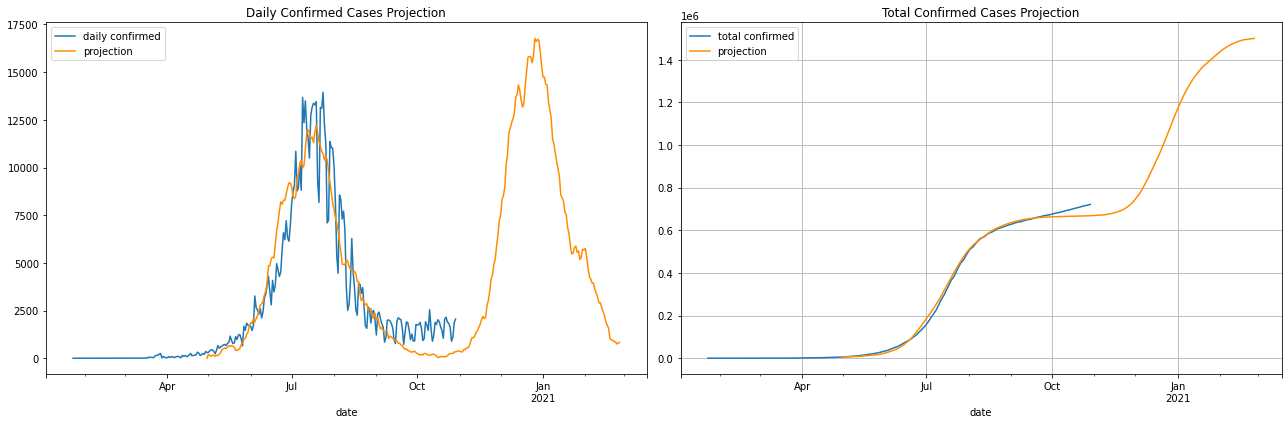



Simulation 2: using 50% end-to-end aggregated interventions:


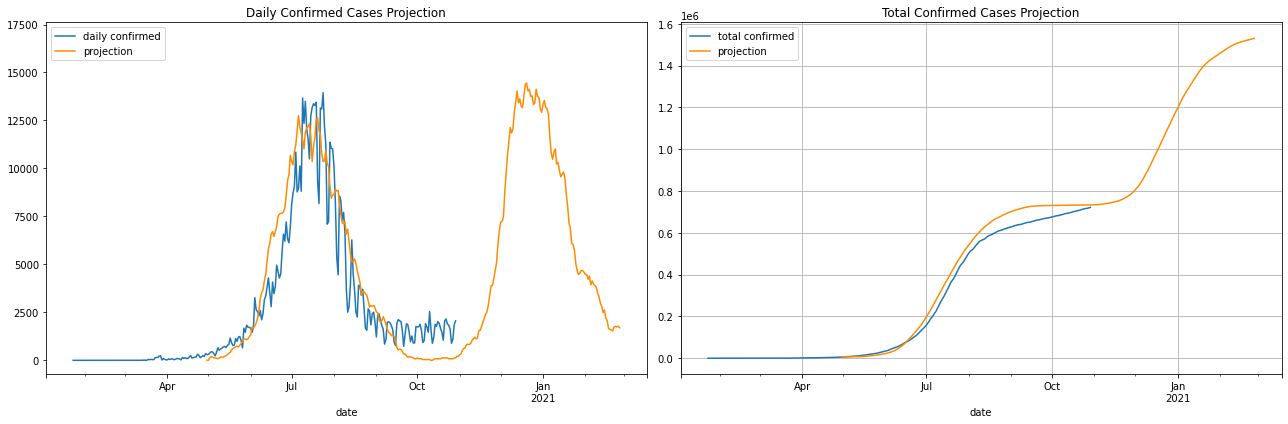



Simulation 3: using 90% end-to-end aggregated interventions:


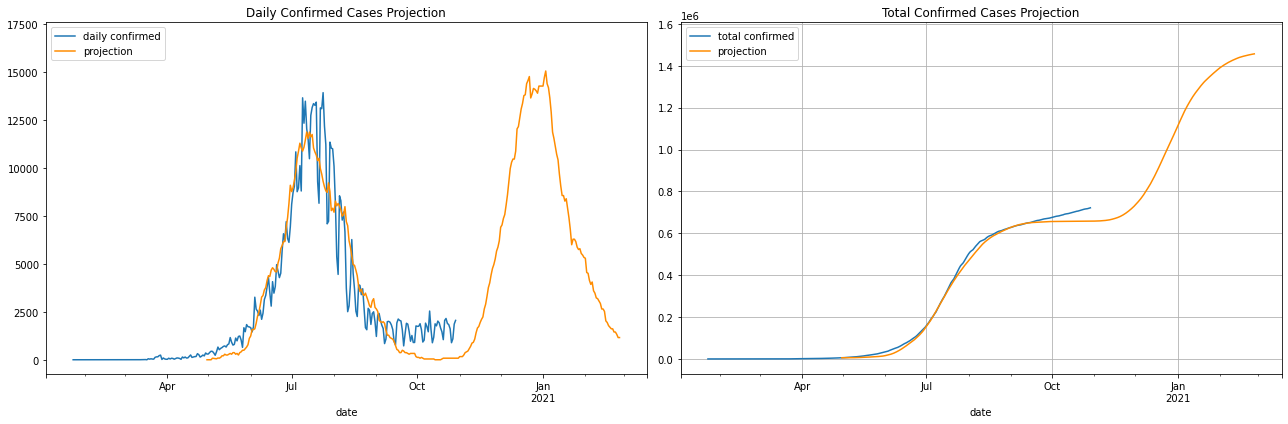

Total Time Taken: 0:10:31.960062


In [6]:
country_code, state, state_population, actual_testing_capacity = 'ZAF', 'South Africa', 57000000, 50000
future_projection_days = 120

run (country_code, state, state_population, actual_testing_capacity, future_projection_days, country_level_projection=True)